# Survey Comparison w/ Current ABM Airport.SAN Model Configs

In [10]:
# compare airport arrival vs departure data and behavior

## Set-up

### Basics

In [93]:
import numpy as np
import os
import pandas as pd
import seaborn as sns

from matplotlib import pyplot as plt

In [ ]:
survey_data_path = r"..\..\data\processed\data_model_output_taz.csv"
configs_path = r"T:\ABM\release\ABM\version_15_2_1\common\src\asim\configs\airport.SAN"
# os.listdir(configs_path)

In [95]:
# TODO: discuss how to handle critical validation errors
survey_data_base = pd.read_csv(survey_data_path)
survey_data_initial_len = survey_data_base.shape[0]
survey_data_base = (
    survey_data_base
        .drop(columns = ['Unnamed: 0'])
        .query("validation_severity_person != 'Critical'")
        .query("validation_severity_trip != 'Critical'")
        .query("~purpose_segment.str.contains('other')")
)
survey_data_base['purpose_segment'] = survey_data_base['purpose_segment'].str.lower()
print(f'dropped {survey_data_initial_len-survey_data_base.shape[0]} responses')

C:\Users\mwe\AppData\Local\Temp\ipykernel_78508\3199861996.py:2: DtypeWarning: Columns (7,8,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,41,42,45,49,52,57,58,60,61,62,64,69,71,78,79,80,81,82,83,84,85,86,87,88,89,90,91,92,93,94,95,96,97,98,99,100,101,102,103,104,105,111,115,116,118,119,126,127,132,133,141,142,143,145,152,156,158,161,173,175,208,214,215,216,218,220,221,223,224,225,226,227,245,258,259,260,261,309) have mixed types. Specify dtype option on import or set low_memory=False.
  survey_data_base = pd.read_csv(survey_data_path)


dropped 0 responses


In [96]:
survey_nonweight_cols = [col for col in survey_data_base.columns if 'weight' not in col]
survey_melt = survey_data_base.melt(id_vars = survey_nonweight_cols, var_name = 'source', value_name = 'weight')
survey_melt.head()

,unique_id,is_valid_record,time_completed,record_type_synthetic,access_mode,access_mode_frequency_label,access_mode_grouped_label,access_mode_label,access_mode_other,age_label,...,walk_prm_time,walk_prm_fare,party_size_label_transformed,purpose_segment,taxi_fare_model,tnc_fare_model,taxi_mean_wait_model,tnc_mean_wait_model,source,weight
0,1,True,08:41:12,0,NaN,NaN,NaN,NaN,NaN,AGE_45_49,...,NaN,7.50,NaN,employee,41.891846,14.623992,13.3,8.4,weight_departing_and_arriving,5.077165
1,2,True,08:40:04,0,1.0,NaN,WALK,WALK,NaN,AGE_25_29,...,80.501824,2.75,NaN,employee,40.430652,14.198917,17.3,8.5,weight_departing_and_arriving,4.749957
2,3,True,08:51:36,0,NaN,NaN,NaN,NaN,NaN,AGE_35_39,...,63.415579,2.50,NaN,employee,23.796498,9.359890,9.5,6.3,weight_departing_and_arriving,5.077165
3,4,True,10:32:58,0,1.0,NaN,WALK,WALK,NaN,AGE_20_24,...,57.323354,2.50,NaN,employee,20.487802,9.190000,5.5,3.0,weight_departing_and_arriving,4.749957
4,5,True,11:09:46,0,1.0,NaN,WALK,WALK,NaN,AGE_50_54,...,81.256295,2.75,NaN,employee,32.687884,11.946475,9.5,6.3,weight_departing_and_arriving,4.749957


### Utils

In [97]:
purpose_order = ['resident_business',
                'resident_non_business',
                'visitor_business',
                'visitor_non_business',
                'external',
                'employee']

def clustered_bar_charts(survey_melt, config_compare, x, xlabel, title_adj = ''):
    """
    """
    # survey_melt = survey_compare.melt(id_vars=x, var_name='variable')
    if 'source' not in survey_melt.columns:
        survey_melt['source'] = 'Survey'
    config_melt= config_compare.melt(id_vars=x, var_name='purpose_segment')
    config_melt['source'] = 'Config'
    arr_dep_compare = pd.concat([survey_melt, config_melt])

    for purpose in purpose_order:
        _, ax = plt.subplots(figsize=(20,7))
        sns.barplot(
            data = (
                arr_dep_compare
                    .query(f'purpose_segment == "{purpose}"')# | purpose_segment == "{survey_col}"')
            ),
            x=x,
            y='value',
            hue='source'
        )
        ax.tick_params(axis='x', labelrotation=90)
        plt.title(f'{title_adj}{purpose}', fontsize=25)
        plt.ylabel("% Share", fontsize=20)
        plt.xlabel(xlabel, fontsize=20)
        plt.grid()
        plt.show()


## Arrival & Departure
ERROR: 171 OUTBOUND_FROM_AIRPORT respondents missing trip_start_times ...

They are not synthetic

Use flight_arrival_time + half an hr (for maybe half of respondents)?

### Survey

In [98]:
# # select direction
# direction = "INBOUND_TO_AIRPORT"
# # direction = "OUTBOUND_FROM_AIRPORT"
# survey_data_dir = survey_melt.copy()#.query(f'inbound_or_outbound_label == "{direction}"')

In [99]:
                # 'NEITHER_OTHER_SPECIFY',etc #drop these columns - %s are of each column so does not impact analysis
# # no employee data in outbound survey data
# if direction == 'OUTBOUND_FROM_AIRPORT':
#     purpose_order_adj = purpose_order[:-1]
# else:
#     purpose_order_adj = purpose_order

##### Label Arrival Times Using Config Structure

In [100]:
# map survey arrival times to config groupings
survey_config_labels = {}
for period in survey_data_base['trip_arrival_time'].dropna().unique():
    start_hr = int(np.floor((period-1)/2) + 5)
    if period >= 39:
        survey_config_labels[period] = '12am-5am'
    elif period%2 == 1:
        survey_config_labels[period] = f'{start_hr}:00 to {start_hr}:30'
    elif period%2 == 0:
        survey_config_labels[period] = f'{start_hr}:30 to {start_hr+1}:00'
# survey_config_labels

In [101]:
survey_melt['trip_arrival_time_adjusted'] = (
        survey_melt
            ['trip_arrival_time']
            .where(survey_melt['trip_arrival_time']<=38, int(0))
            )
survey_melt['period_map'] = (
                            survey_melt
                                ['trip_arrival_time']
                                .map(survey_config_labels)
                            )
# survey_melt[['trip_arrival_time_label','trip_arrival_time_mapped_config']].drop_duplicates().sample(5)

##### Pivot Survey Data

In [ ]:
survey_purp_total = (
                survey_melt
                    .groupby(['source','purpose_segment'])
                    ['weight']
                    .sum()
                    .reset_index(drop=False)
                )
survey_time_purp_compare = (
                survey_melt
                    .groupby(['source','purpose_segment','trip_arrival_time_adjusted','period_map'])
                    ['weight']
                    .sum()
                    .reset_index(drop=False)
                )
survey_time_purp_compare = (
    survey_time_purp_compare
    .merge(
        survey_purp_total,
        on=['source','purpose_segment']
        )
    )
survey_time_purp_compare['weight'] = survey_time_purp_compare['weight_x'].div(survey_time_purp_compare['weight_y'])
survey_time_purp_compare.drop(columns = ['weight_x','weight_y'],inplace=True)
survey_time_purp_compare.head()

,source,purpose_segment,trip_arrival_time_adjusted,period_map,weight
0,weight_departing_and_arriving,employee,0.0,12am-5am,0.044379
1,weight_departing_and_arriving,employee,1.0,5:00 to 5:30,0.035806
2,weight_departing_and_arriving,employee,2.0,5:30 to 6:00,0.042686
3,weight_departing_and_arriving,employee,3.0,6:00 to 6:30,0.046810
4,weight_departing_and_arriving,employee,4.0,6:30 to 7:00,0.069265


In [173]:
(
    survey_time_purp_compare
    .query('source == "weight_departing_only"')
    .pivot_table(
        index= 'trip_arrival_time_adjusted',
        columns= 'purpose_segment',
        values='weight' #_departing_only'
    )
)

purpose_segment,employee,resident_business,resident_non_business,visitor_business,visitor_non_business
trip_arrival_time_adjusted,,,,,
0.0,0.044366,0.003675,0.003438,0.001400,0.000468
1.0,0.035819,0.001433,0.003215,0.002171,0.001031
2.0,0.042674,0.005107,0.004696,0.003157,0.003241
3.0,0.046811,0.013463,0.011022,0.004307,0.005469
4.0,0.069422,0.051364,0.021140,0.008002,0.014512
5.0,0.056586,0.031861,0.050698,0.049361,0.022888
6.0,0.061449,0.109940,0.057525,0.022882,0.035572
7.0,0.069182,0.073618,0.074523,0.055743,0.025536
8.0,0.085201,0.044554,0.090377,0.039296,0.032225


### Config Data

In [103]:
# config_direction = {'INBOUND_TO_AIRPORT': 'departure',
#                     'OUTBOUND_FROM_AIRPORT': 'arrival'}
config_dir_time_purp = pd.read_csv(os.path.join(configs_path, f'airport_departure.SAN.csv'))
# config_outbound_time_purp = pd.read_csv(os.path.join(configs_path, f'airport_arrival.SAN.csv'))

In [104]:
config_purpose_dict = {
    'purp0_perc': 'resident_business', 'purp1_perc': 'resident_non_business',
    'purp2_perc': 'visitor_business','purp3_perc': 'visitor_non_business',
    'purp4_perc': 'external', 'purp5_perc': 'employee' #TODO Verify purp5 value
    # TODO - investigate "External" mode
}
config_dir_time_purp.rename(columns = config_purpose_dict, inplace=True)

In [105]:
# map config time_periods to new format for comparison w/ survey data
config_period_labels = {}
for period in config_dir_time_purp['period']:
    start_hr = int(period/2 + 4)
    if period == 0:
        config_period_labels[period] = '12am-5am'
    elif period == 1:
        config_period_labels[period] = '12am-5am'
    elif period == 40:
        config_period_labels[period] = 'After 12am'
    elif period%2 == 0:
        config_period_labels[period] = f'{start_hr}:00 to {start_hr}:30'
    elif period%2 == 1:
        config_period_labels[period] = f'{start_hr}:30 to {start_hr+1}:00'

config_dir_time_purp['period_map'] = config_dir_time_purp['period'].map(config_period_labels)
config_dir_time_purp = config_dir_time_purp[['period_map'] + list(config_dir_time_purp.columns[1:-1])]

In [106]:
config_dir_time_purp = (
    config_dir_time_purp
    .groupby("period_map")
    .sum()
    .reset_index(drop=False)
)
sort_dict = {v: k for k, v in config_period_labels.items()}
config_dir_time_purp = (
    config_dir_time_purp
        .iloc[config_dir_time_purp['period_map'].map(sort_dict).argsort()]
        .reset_index(drop=True)
)
config_dir_time_purp.head()

,period_map,resident_business,resident_non_business,visitor_business,visitor_non_business,external,employee
0,12am-5am,0.098,0.080,0.046,0.040,0.073,0.044
1,5:00 to 5:30,0.082,0.049,0.030,0.026,0.033,0.044
2,5:30 to 6:00,0.056,0.048,0.032,0.026,0.029,0.044
3,6:00 to 6:30,0.086,0.068,0.045,0.035,0.047,0.034
4,6:30 to 7:00,0.058,0.056,0.031,0.029,0.021,0.034


### Compare

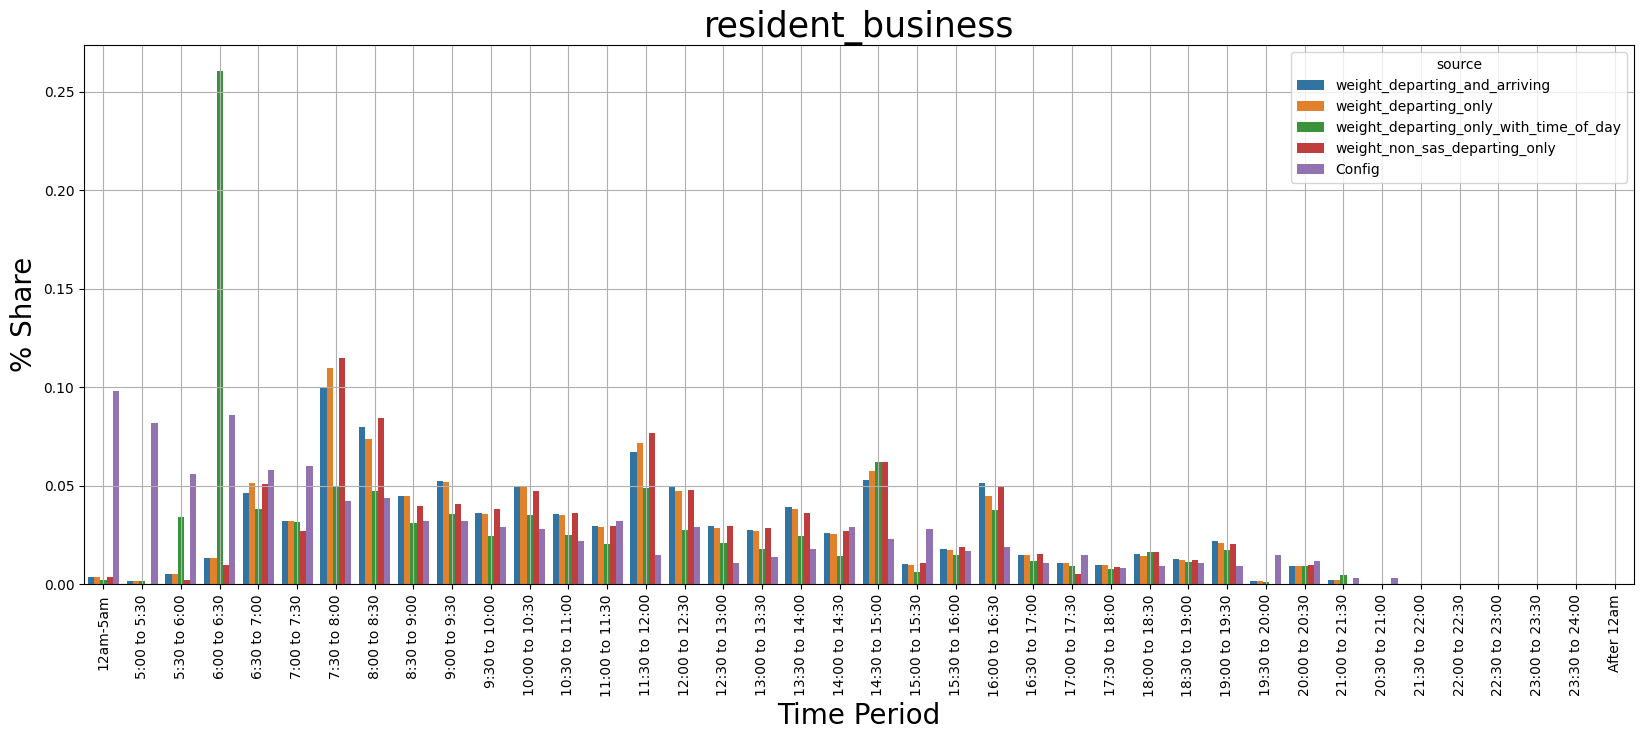

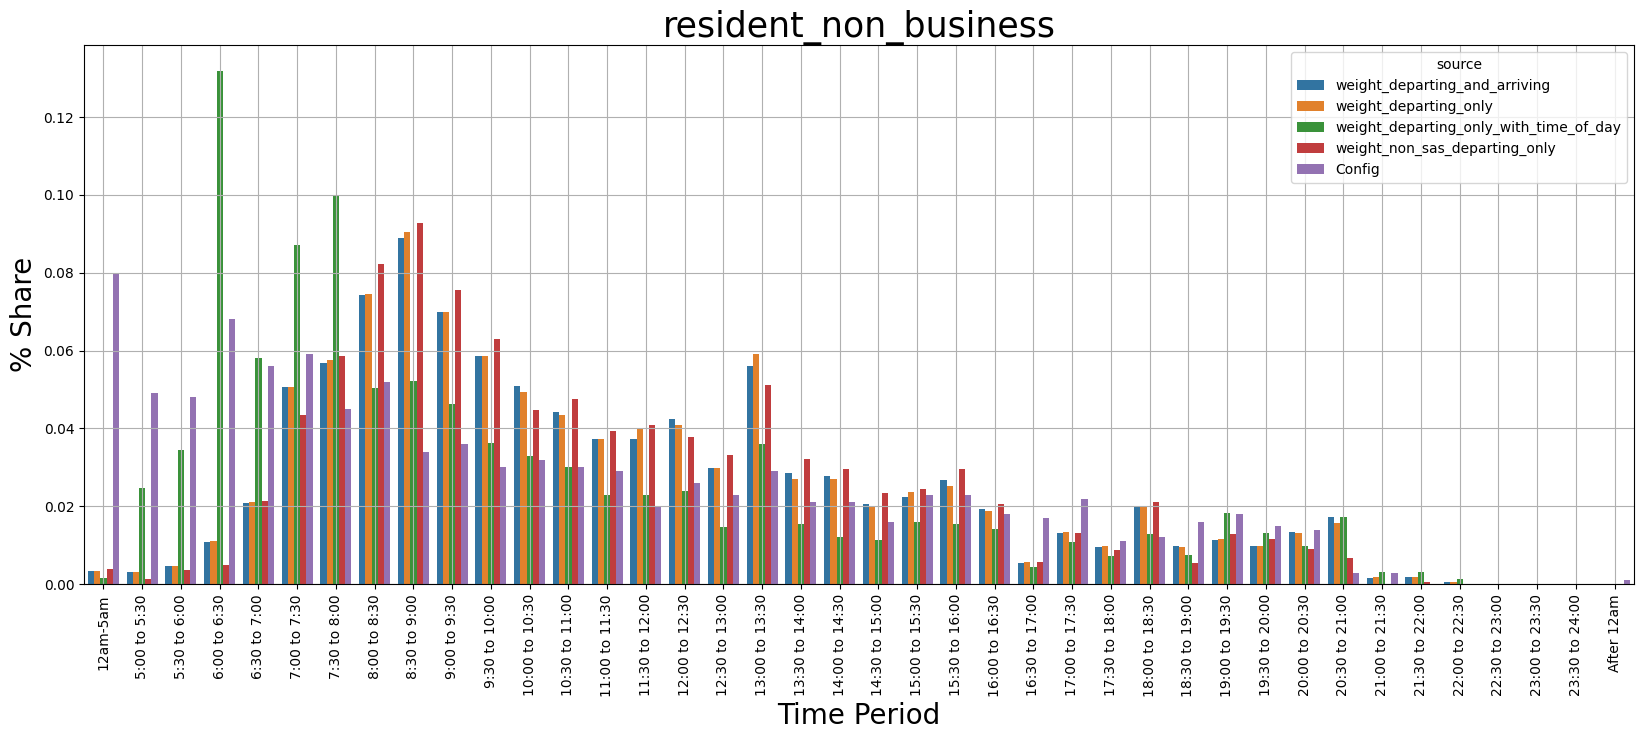

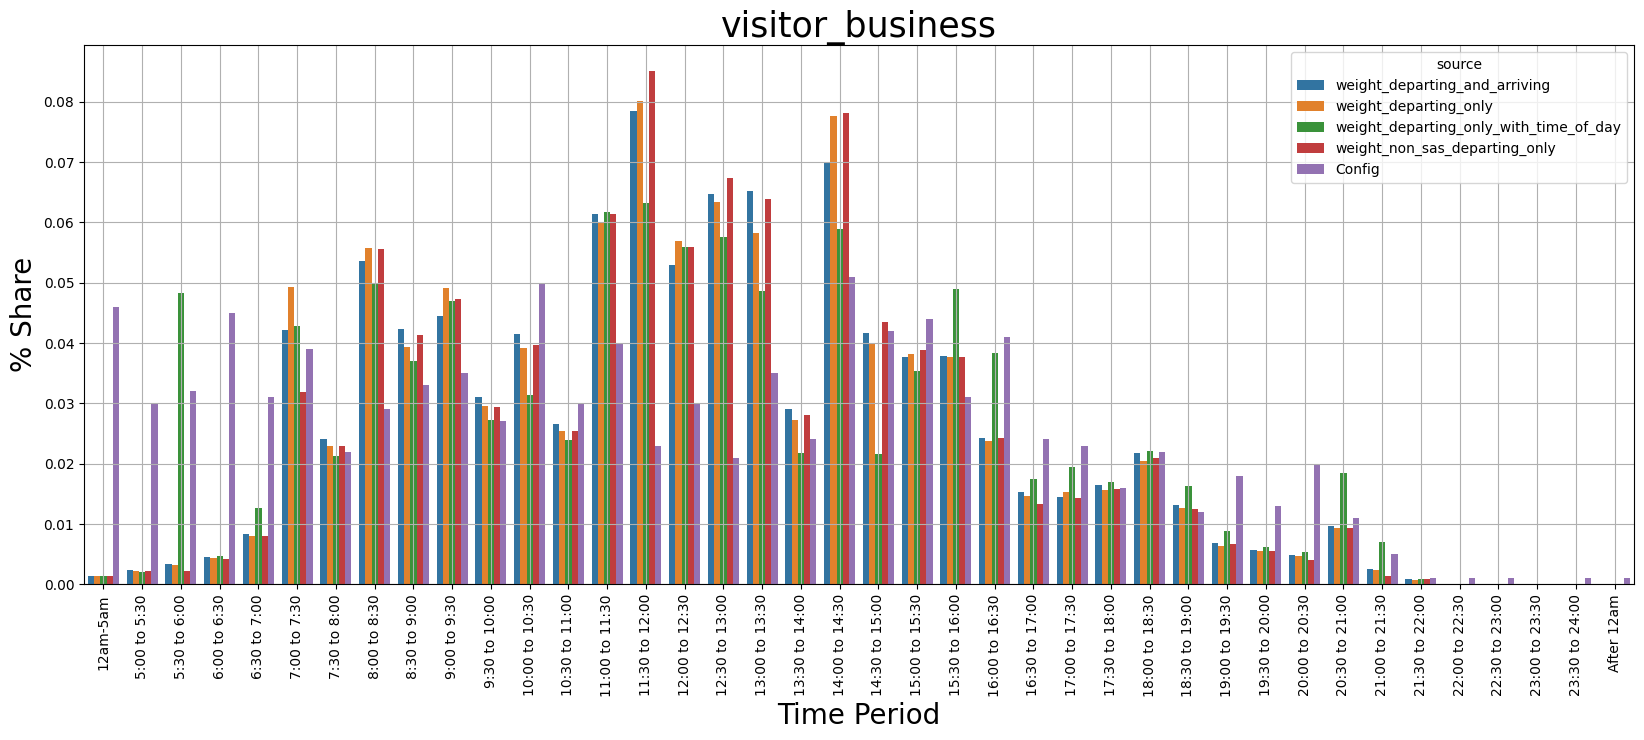

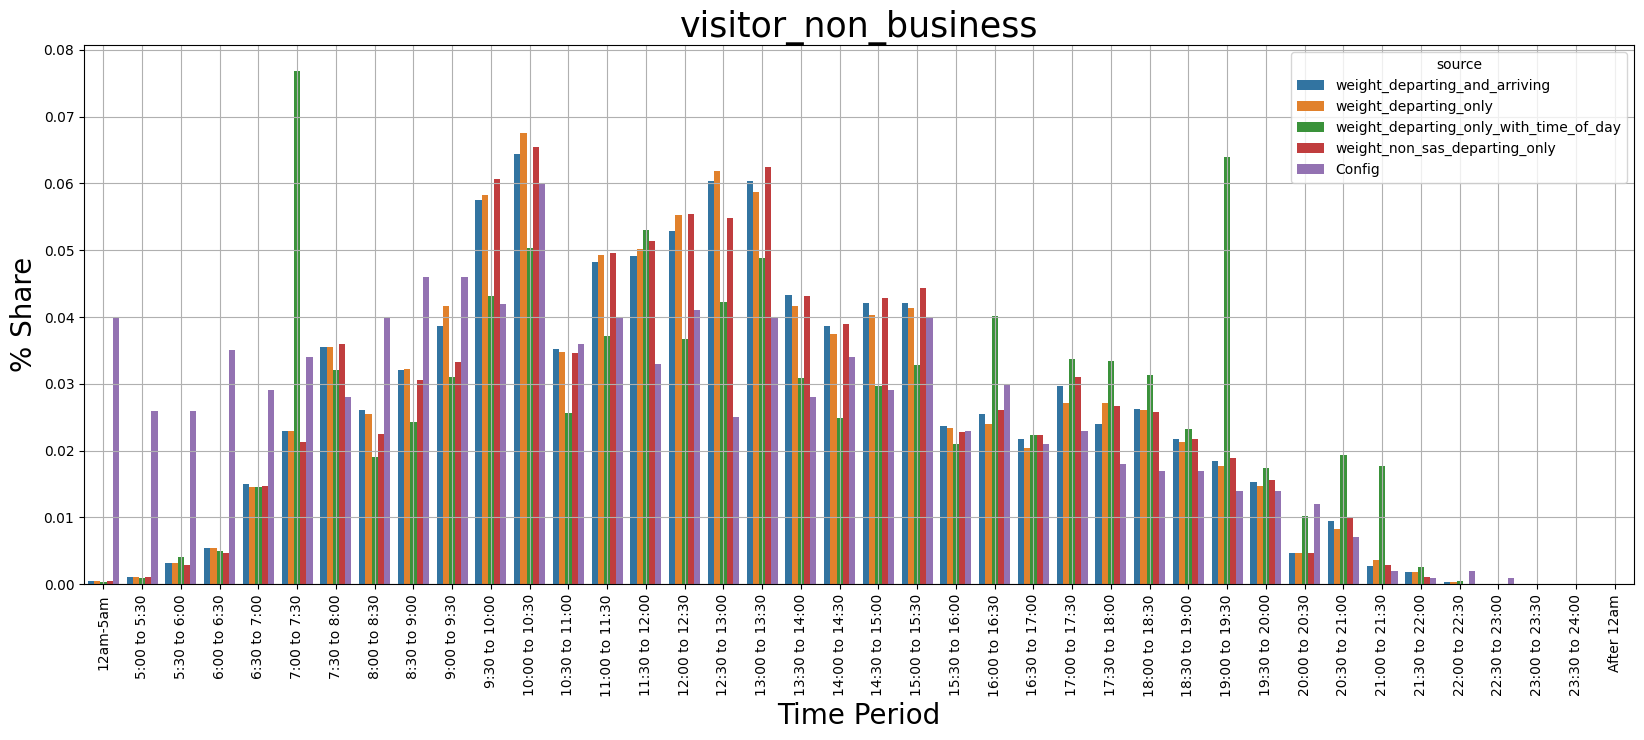

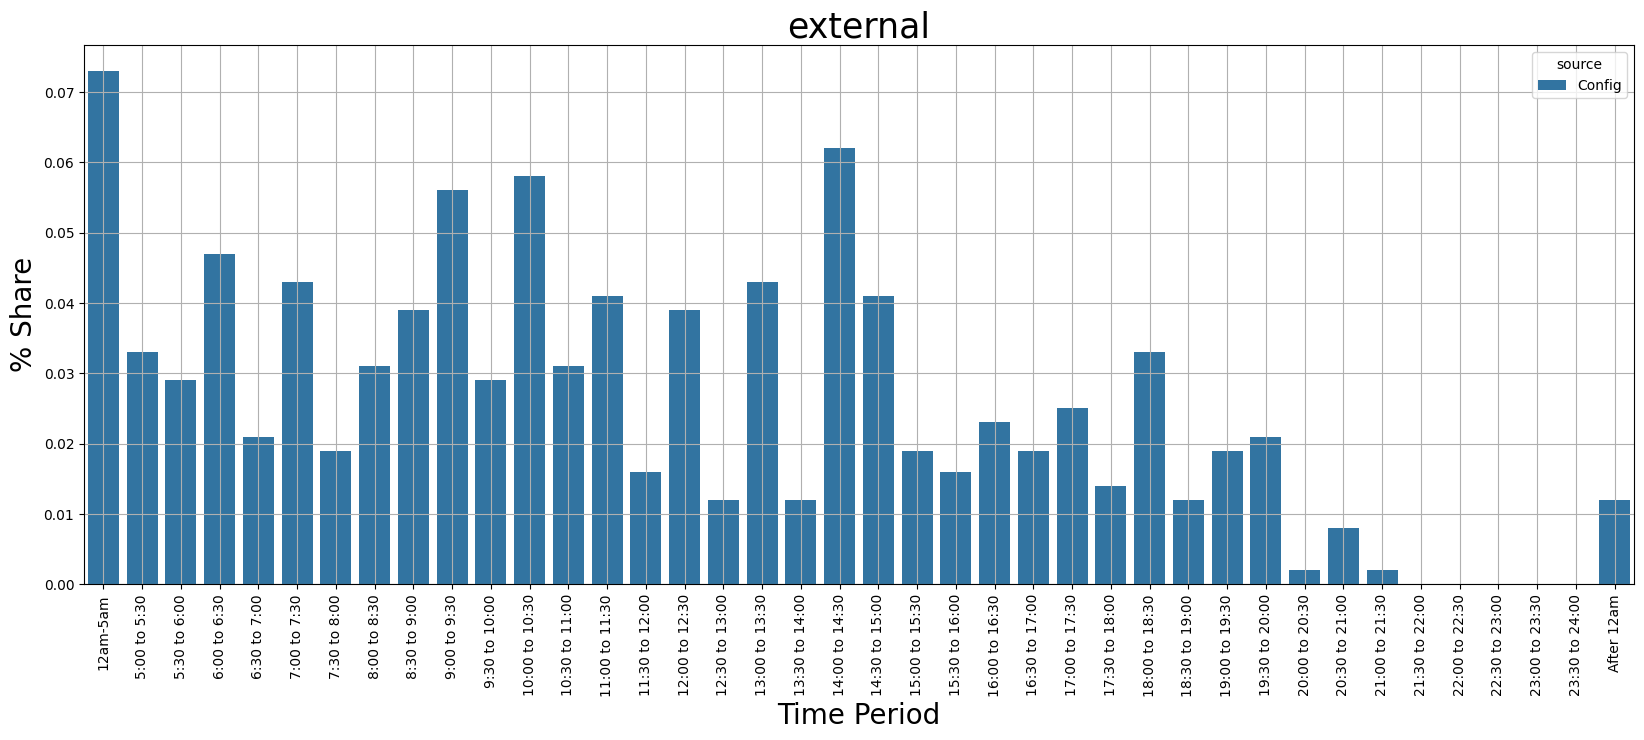

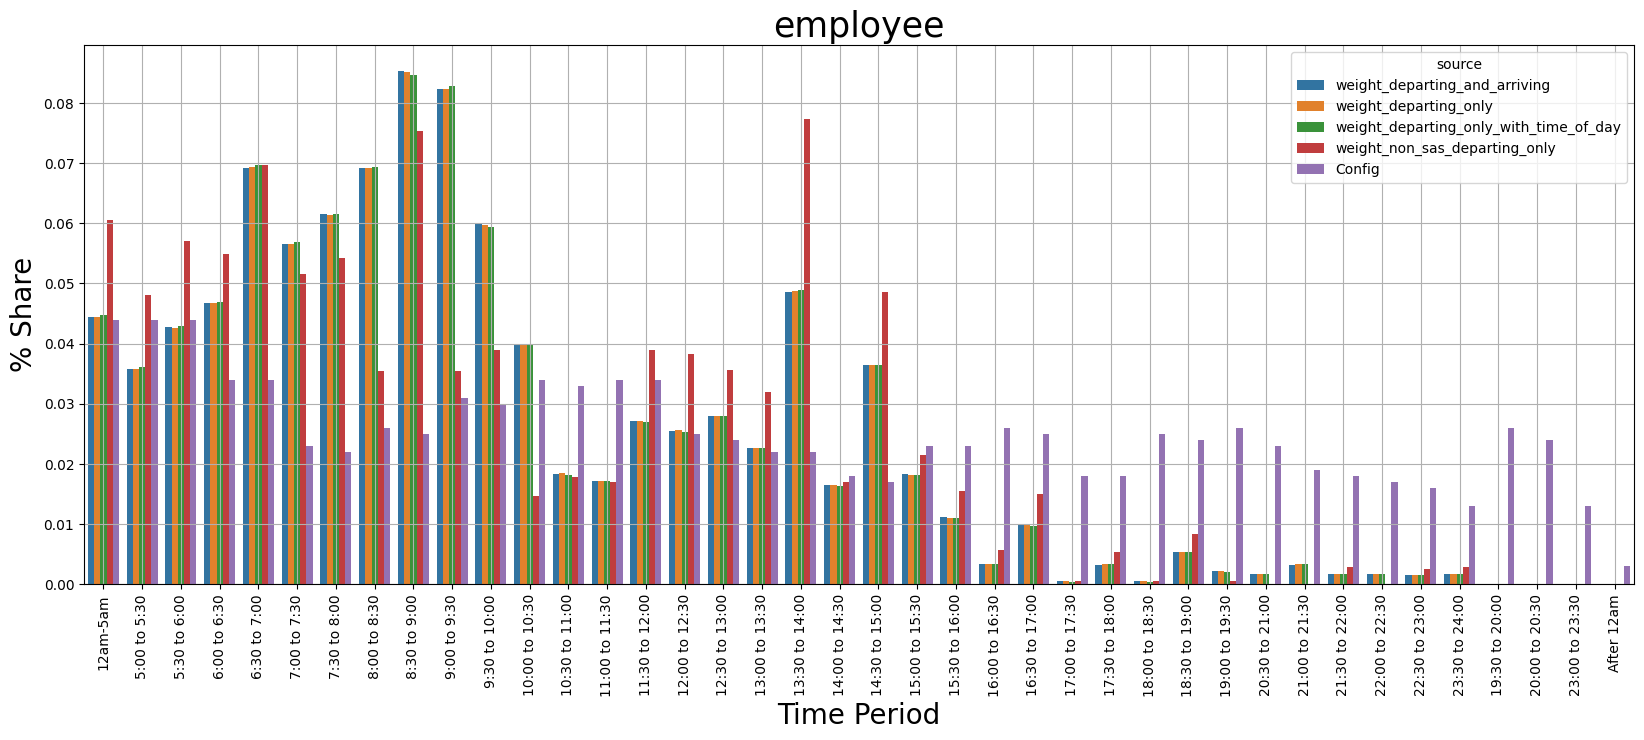

In [107]:
survey_compare = survey_time_purp_compare.rename(columns={'weight':'value'})
config_compare = config_dir_time_purp #currently only inbound
x = 'period_map'
xlabel = "Time Period"
# title_adj = f'{direction}: '
clustered_bar_charts(survey_compare, config_compare, x, xlabel)#, title_adj)

## airport_purpose

### Survey

In [108]:
survey_purp_total = (
                survey_melt
                    .groupby(['source','purpose_segment'])
                    ['weight']
                    .sum()
                    .reset_index(drop=False)
                )
survey_purp_compare = (
                survey_melt
                    .groupby(['source'])
                    ['weight']
                    .sum()
                    .reset_index(drop=False)
                )
survey_purp_compare = (
    survey_purp_compare
    .merge(
        survey_purp_total,
        on=['source']
        )
    )
survey_purp_compare['proportion'] = survey_purp_compare['weight_y'].div(survey_purp_compare['weight_x'])
survey_purp_compare.drop(columns = ['weight_x','weight_y'],inplace=True)
survey_purp_compare.head()

,source,purpose_segment,proportion
0,weight_departing_and_arriving,employee,0.109030
1,weight_departing_and_arriving,resident_business,0.075810
2,weight_departing_and_arriving,resident_non_business,0.260317
3,weight_departing_and_arriving,visitor_business,0.177895
4,weight_departing_and_arriving,visitor_non_business,0.376949


### Config

In [109]:
config_purp = pd.read_csv(os.path.join(configs_path, 'airport_purpose.SAN.csv'), names =['purpose','proportion'], skiprows=1)
config_purpose_simplified_mapping = {int(key[4]):value for key,value in config_purpose_dict.items()}
config_purp['purpose_segment'] = config_purp['purpose'].map(config_purpose_simplified_mapping)
config_purp['source'] = 'Config'
config_purp = config_purp[['purpose_segment', 'proportion', 'source']]

### Compare

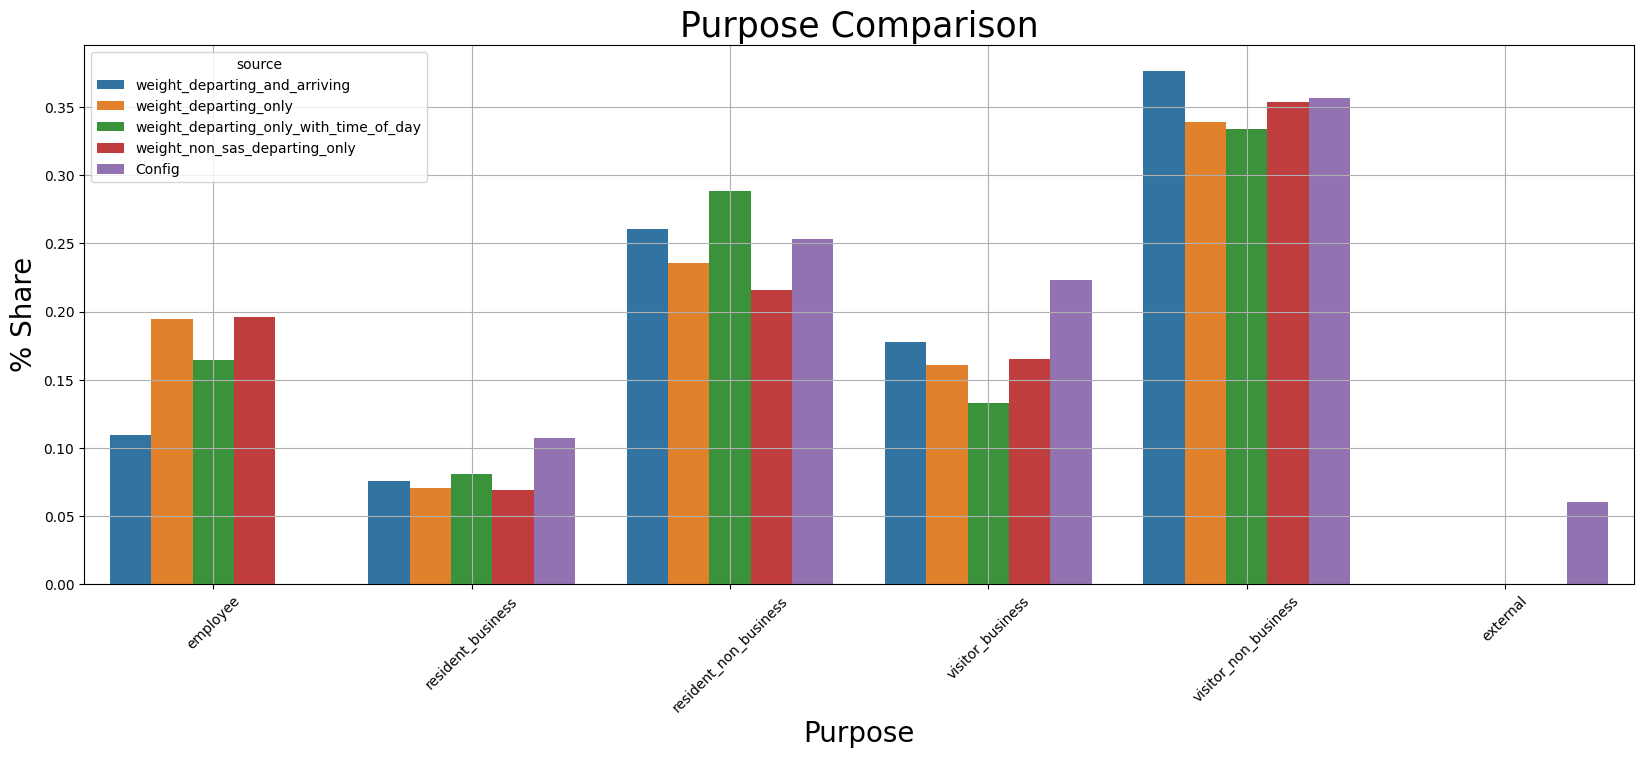

In [110]:
compare_purp = pd.concat([survey_purp_compare, config_purp])

_, ax = plt.subplots(figsize=(20,7))
sns.barplot(
    data = compare_purp,
    x='purpose_segment',
    y='proportion',
    hue='source'
)
ax.tick_params(axis='x', labelrotation=45)
plt.title(f'Purpose Comparison', fontsize=25)
plt.ylabel("% Share", fontsize=20)
plt.xlabel('Purpose', fontsize=20)
plt.grid()
plt.show()

## Employee Park
'airport_employee_park.SAN.csv'

can be received from airport, can amend portions by rule-of-thumb

will this change over time? ask SAN

In [111]:
survey_data_base.groupby(['main_mode_label','parking_location_label'])['unique_id'].count().head()

main_mode_label               parking_location_label             
DROPPED_OFF_BY_FAMILY_FRIEND  OFF_AIRPORT_PARKING                      3
                              OTHER                                    2
                              TERM1_PARKING_PLAZA                      2
                              TERM2_PARKING_PLAZA                      3
DROVE_ALONE_AND_PARKED        ADMIN_BUILDING_LOT_2417_MCCAIN_ROAD    112
Name: unique_id, dtype: int64

In [112]:
config_park = pd.read_csv(os.path.join(configs_path, 'airport_employee_park.SAN.csv'))
config_park

,Name,MGRA,Employee Stalls,Share to Terminal,Public Transit Share to Terminal
0,1,9080,225,1.0,0
1,2,11251,225,1.0,0
2,3,11243,230,0.9,0
3,4,11244,1985,0.1,0


## airport_income
'airport_income.SAN.csv'

issue - large number of 'no responses', reach out to SAN for clarification?

```
# https://sandag.github.io/ABM/inputs.html#airport-income-by-purpose-distribution
# Household income:
# 0 = Less than $25K
# 1 = $25K – $50K
# 2 = $50K – $75K
# 3 = $75K – $100K
# 4 = $100K – $125K
# 5 = $125K – $150K
# 6 = $150K – $200K
# 7 = $200K plus
```


### Survey

In [113]:
survey_income_dict = {
  'LESS_THAN_15K': 0,
  'BETWEEN_15K_20K': 0,
  'BETWEEN_20K_25K': 0,
  'BETWEEN_25K_30K': 1,
  'BETWEEN_30K_35K': 1,
  'BETWEEN_35K_40K': 1,
  'BETWEEN_40K_45K': 1,
  'BETWEEN_45K_50K': 1,
  'BETWEEN_50K_60K': 2,
  'BETWEEN_60K_75K': 2,
  'BETWEEN_75K_100K': 3,
  'BETWEEN_100K_150K': 4,
  'BETWEEN_150_199K': 5,
  'BETWEEN_200_299K': 6,
  'MORE_THAN_300K': 6,
  'PREFER_NOT_TO_SAY': 7
}

In [114]:
survey_income_dict2 = {
    0 : 'Less_than_$25K',
    1 : '$25K–$50K',
    2 : '$50K–$75K',
    3 : '$75K–$100K',
    4 : '$100K–$150K',
    5 : '$150K–$200K',
    6 : '$200Kplus',
    7: 'PREFER_NOT_TO_SAY'
}

In [115]:
survey_income_purp = survey_data_base.copy()

survey_income_purp['income'] = (
        survey_income_purp
            ['household_income_label']
            .map(survey_income_dict)
)

survey_income_purp = (
    survey_income_purp
    .pivot_table(
        index='income',
        columns='purpose_segment',
        aggfunc='sum',
        values='weight_departing_only'
        )
    .fillna(0)
    .apply(lambda x: x/sum(x))
    .round(3)
    # [p.upper() for p in purpose_order]
    .loc[list(survey_income_dict2.keys())]
    .reset_index(drop=False)
    .replace({'income': survey_income_dict2})
)
survey_income_purp.columns.name = None
survey_income_purp

,income,employee,resident_business,resident_non_business,visitor_business,visitor_non_business
0,Less_than_$25K,0.024,0.084,0.044,0.024,0.046
1,$25K–$50K,0.099,0.072,0.075,0.050,0.061
2,$50K–$75K,0.164,0.061,0.084,0.102,0.111
3,$75K–$100K,0.148,0.116,0.084,0.095,0.122
4,$100K–$150K,0.140,0.171,0.144,0.187,0.166
5,$150K–$200K,0.114,0.141,0.130,0.190,0.133
6,$200Kplus,0.095,0.191,0.184,0.147,0.130
7,PREFER_NOT_TO_SAY,0.217,0.165,0.256,0.205,0.231


### Config

In [116]:
config_income_dict = {
    0 : 'Less_than_$25K',
    1 : '$25K–$50K',
    2 : '$50K–$75K',
    3 : '$75K–$100K',
    4 : '$100K–$150K', #group config data to compare to survey
    5 : '$100K–$150K',
    6 : '$150K–$200K',
    7 : '$200Kplus'
}

In [117]:
config_income = (
    pd.read_csv(os.path.join(configs_path, 'airport_income.SAN.csv'))
        .rename(columns = config_purpose_dict)
        .replace({'income': config_income_dict})
        .groupby('income')
        .sum()
)
config_sort_income = {a:b for b,a in config_income_dict.items()}
config_income = (
    config_income
    .iloc[config_income.index.map(config_sort_income).argsort()]
    .reset_index(drop=False)
)
config_income

,income,resident_business,resident_non_business,visitor_business,visitor_non_business,external,employee
0,Less_than_$25K,0.06,0.11,0.03,0.09,0.12,1
1,$25K–$50K,0.09,0.16,0.07,0.15,0.17,0
2,$50K–$75K,0.16,0.19,0.12,0.20,0.16,0
3,$75K–$100K,0.16,0.17,0.15,0.19,0.16,0
4,$100K–$150K,0.25,0.22,0.29,0.21,0.22,0
5,$150K–$200K,0.14,0.07,0.15,0.07,0.09,0
6,$200Kplus,0.14,0.08,0.19,0.09,0.08,0


### Compare

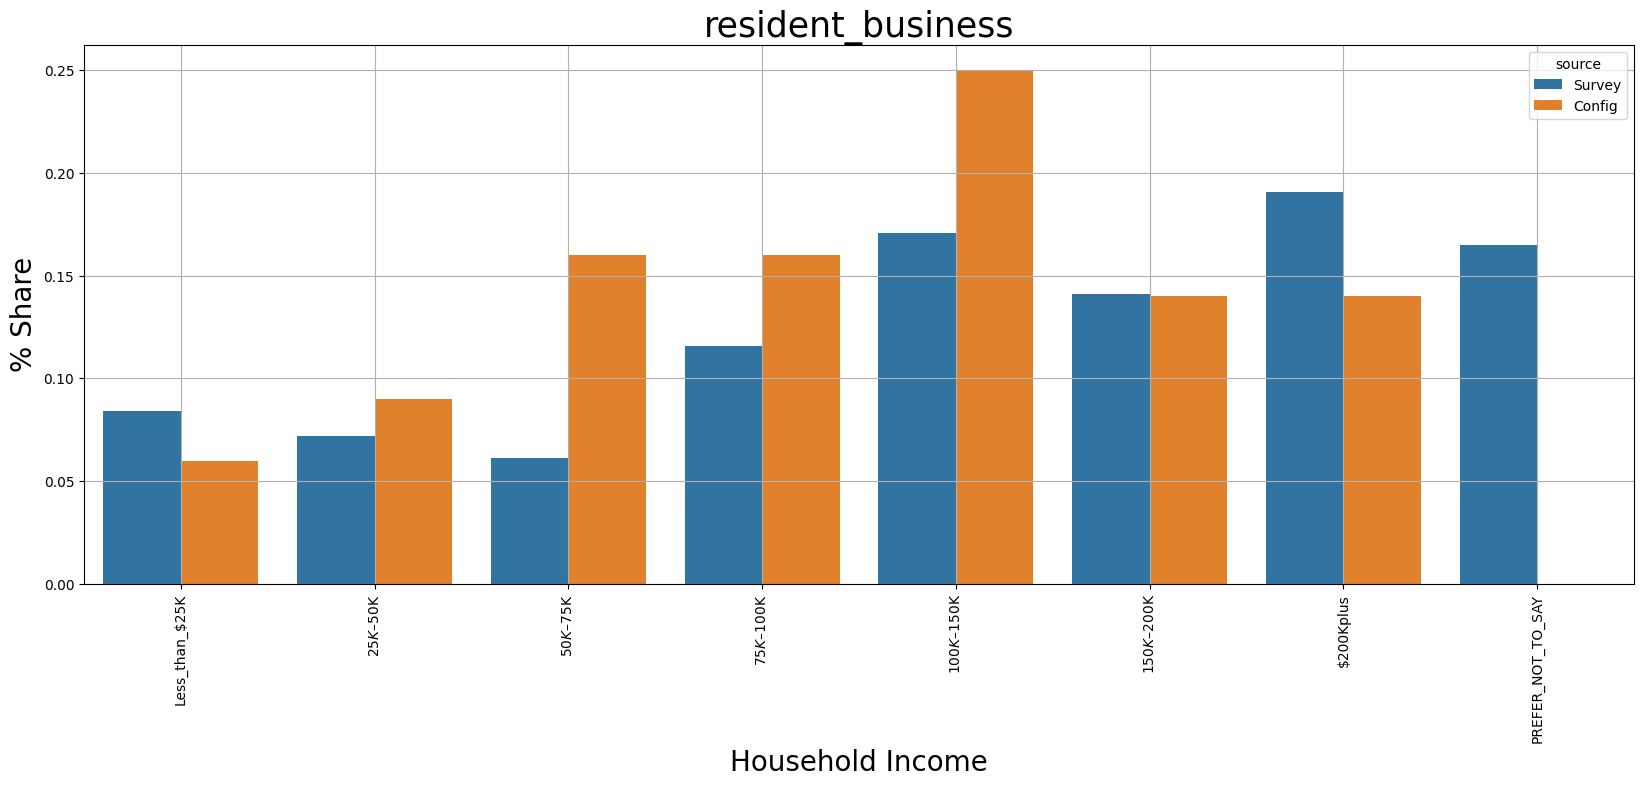

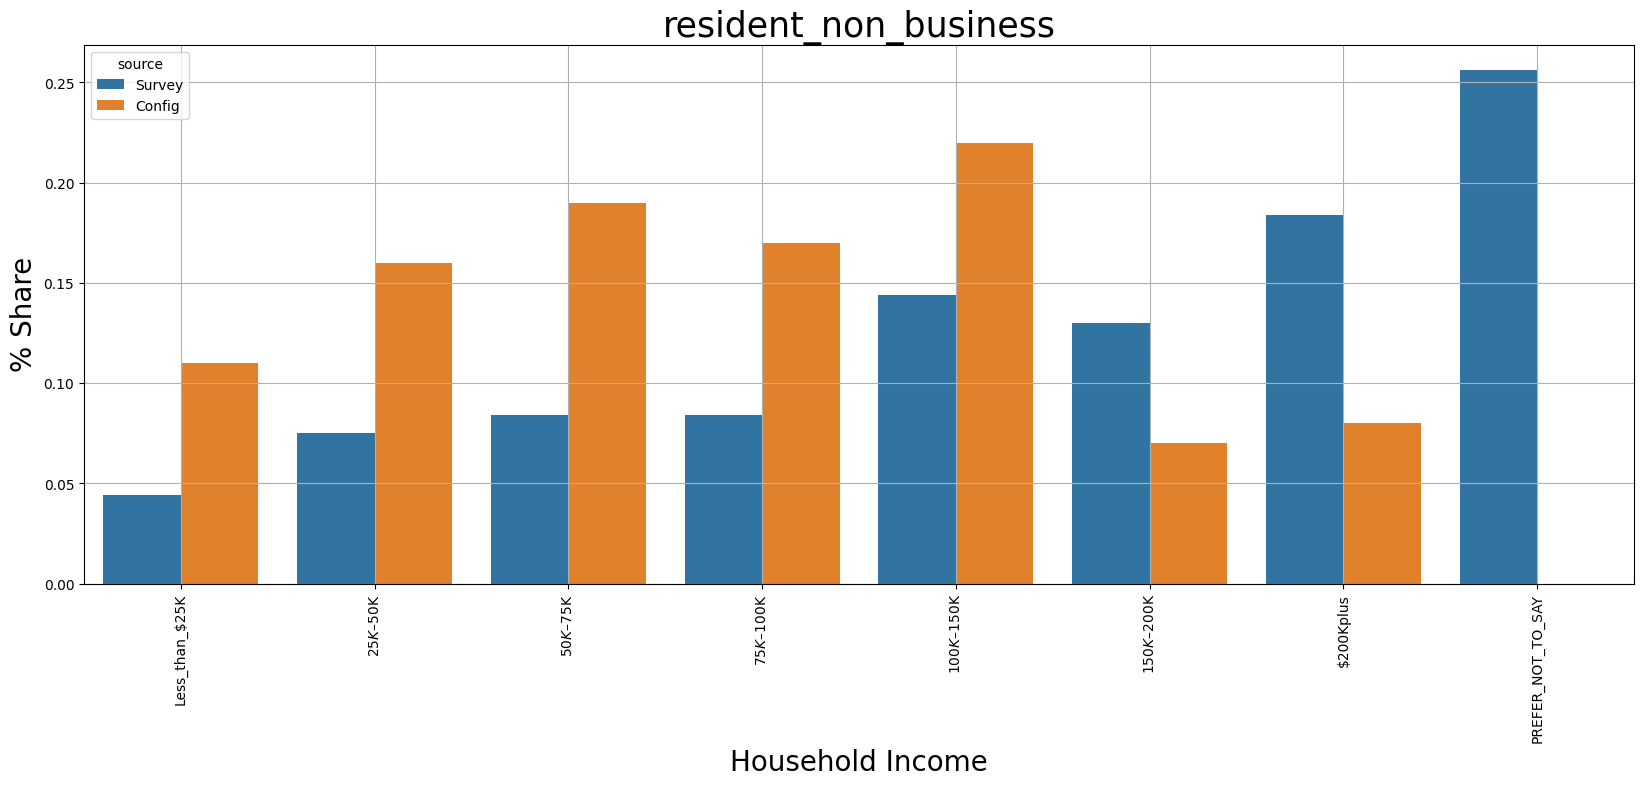

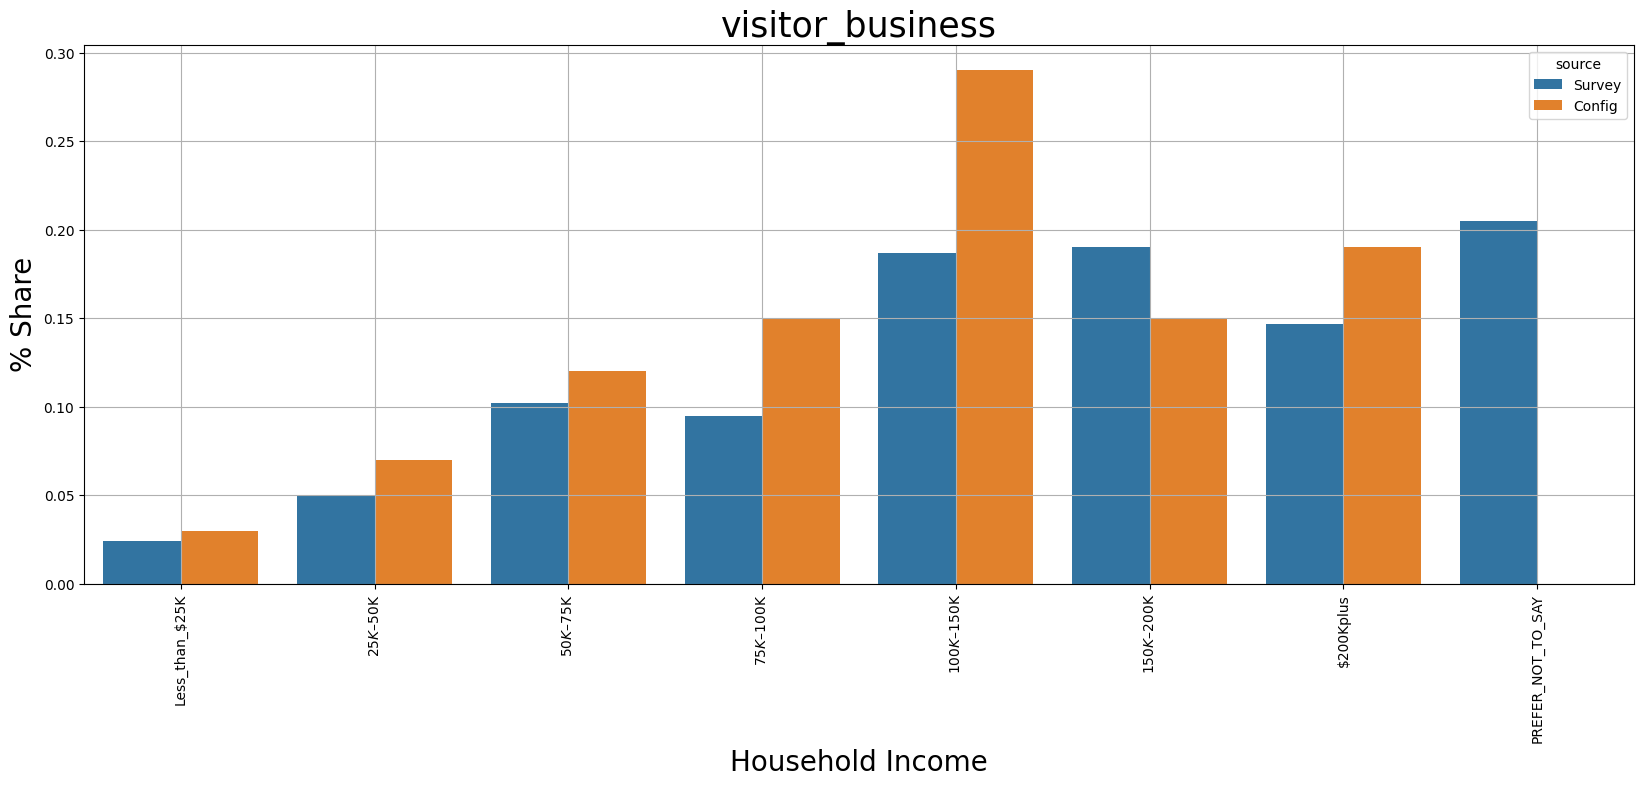

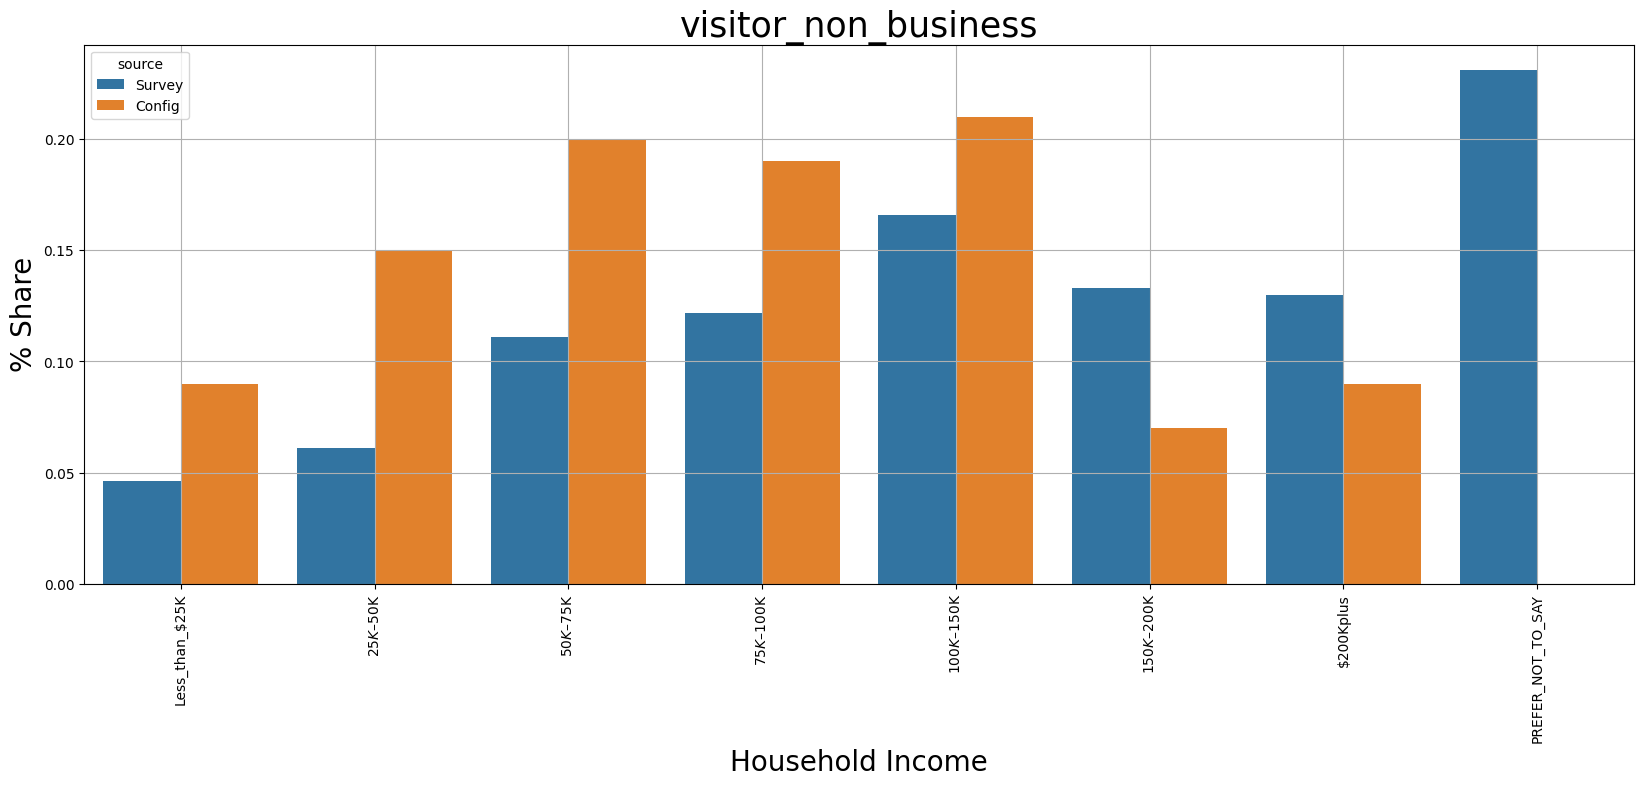

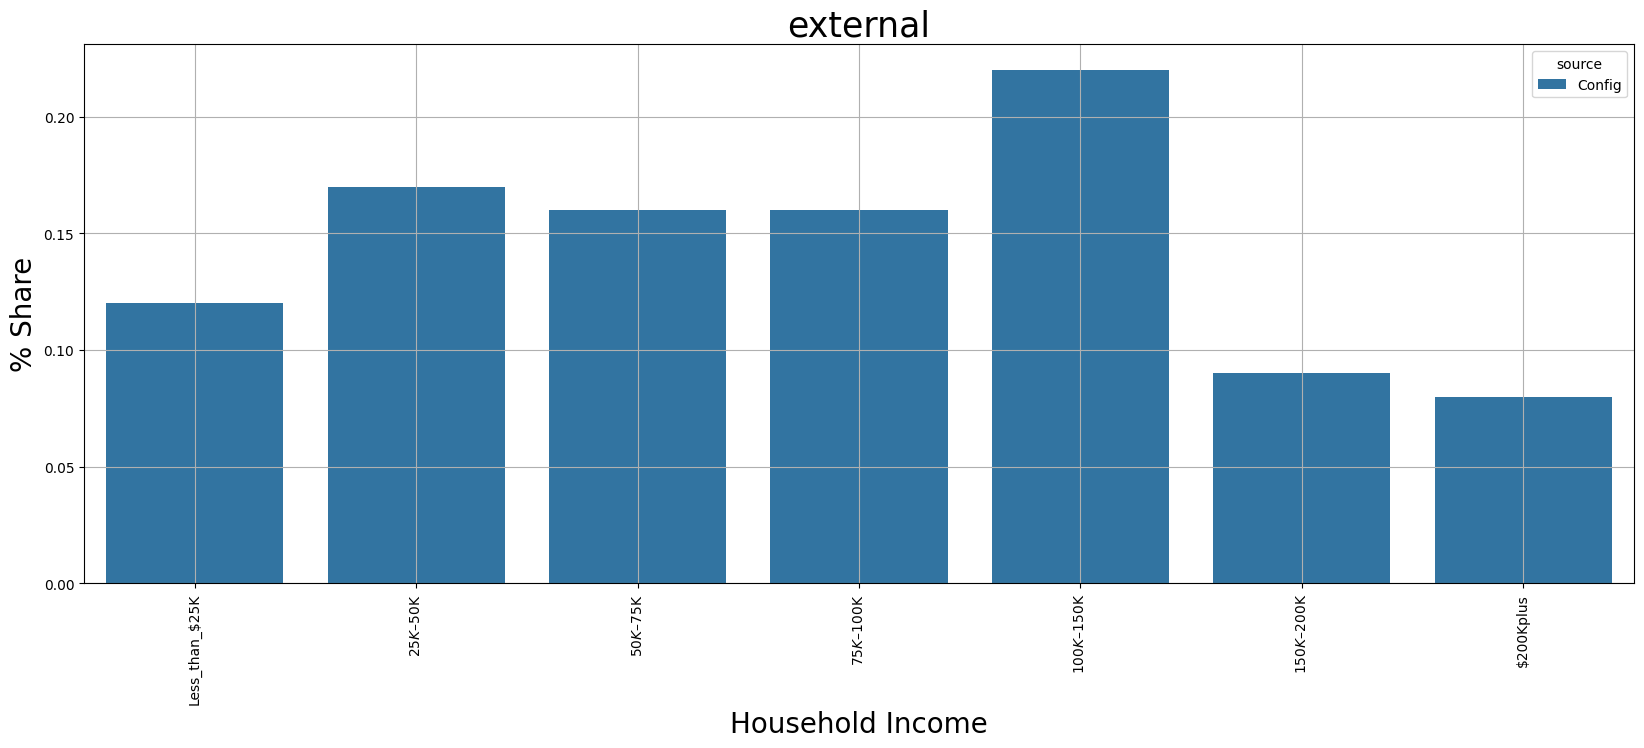

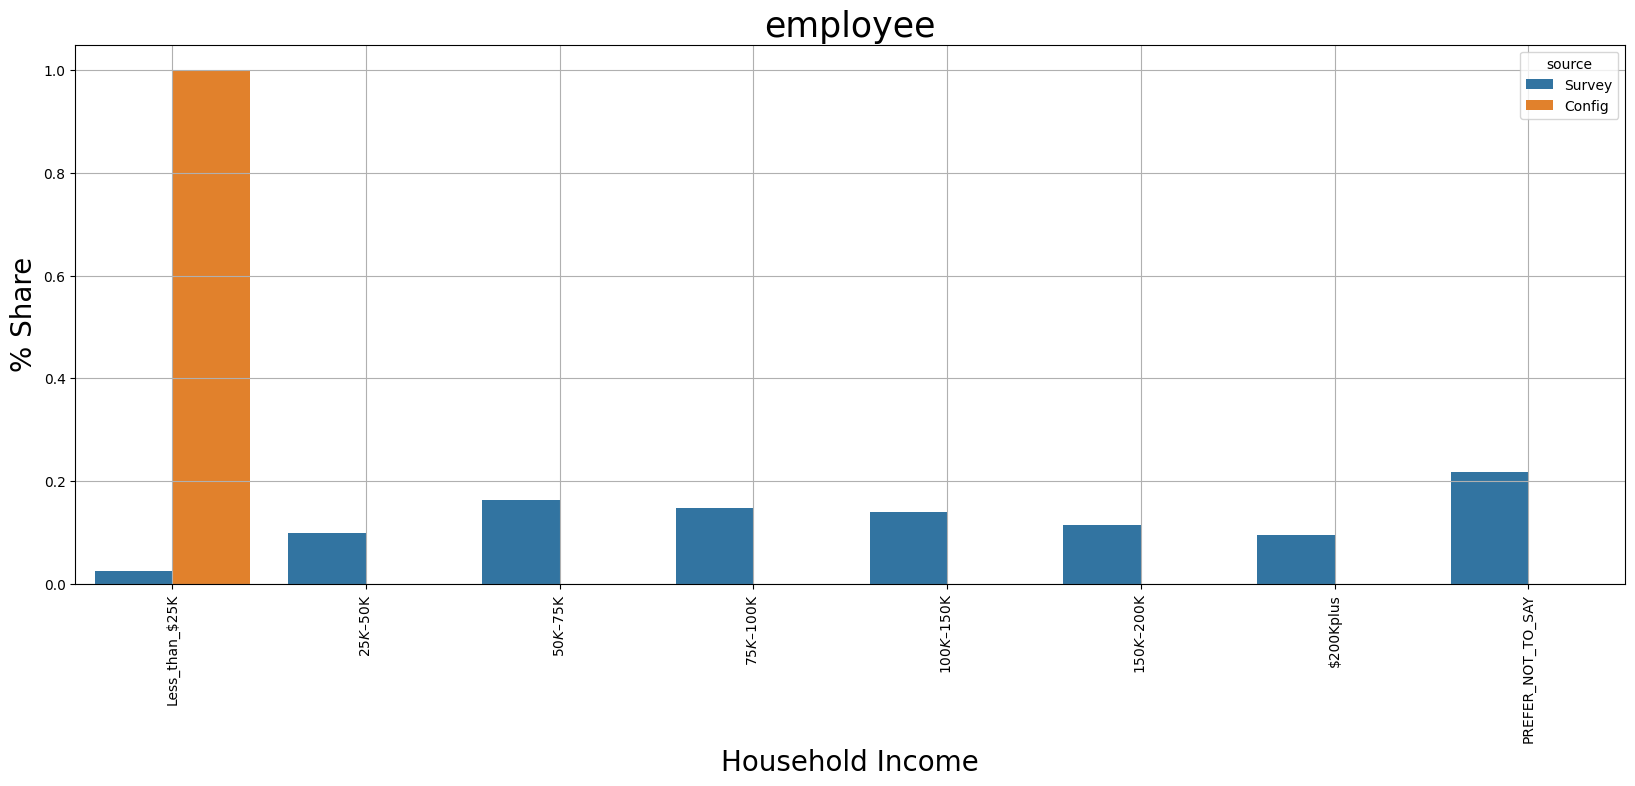

In [118]:
survey_compare = survey_income_purp.melt(id_vars = 'income', var_name = 'purpose_segment')
config_compare = config_income
x = 'income'
xlabel = 'Household Income'
clustered_bar_charts(survey_compare, config_compare, x, xlabel)

## airport_nights
'airport_nights.SAN.csv'

nights - Number of Nights stayed (0 through 14+)

does hotel lobby/business group have data that we could compare to?

In [119]:
### TODO - research when the survey occurred ... airport travelers may stay longer/shorter depending on season
    # airport data - distribution of arrival and departure flights for individuals

### Survey

In [120]:
survey_nights_dict = {
    'NONE': '0',
    'ONE': '1',
    'TWO': '2',
    'THREE': '3',
    'FOUR': '4',
    'FIVE': '5',
    'SIX': '6',
    'SEVEN': '7',
    'EIGHT_TO_TEN': '8-10',
    'ELEVEN_TO_FOURTEEN': '11+',
    'MORE_THAN_FOURTEEN': '11+'
}

In [121]:
survey_night_purp_visited = survey_data_base.copy()

survey_night_purp_visited['nights'] = (survey_night_purp_visited
                                ['nights_visited_label']
                                .map(survey_nights_dict)
                            )

survey_night_purp_visited_compare = (
    survey_night_purp_visited
    .pivot_table(
        index='nights',
        columns='purpose_segment',
        aggfunc='sum',
        values='weight_departing_only'
        )
    .fillna(0)
    .apply(lambda x: x/sum(x))
    .round(3)
    .loc[list(survey_nights_dict.values())[:-1]]
    .reset_index(drop=False)
)
survey_night_purp_visited_compare.columns.name = None
# survey_night_purp_visited_compare

In [122]:
survey_night_purp_away = survey_data_base.copy()

survey_night_purp_away['nights'] = (survey_night_purp_away
                                ['nights_away_label']
                                .map(survey_nights_dict)
                            )

survey_night_purp_away_compare = (
    survey_night_purp_away
    .pivot_table(
        index='nights',
        columns='purpose_segment',
        aggfunc='sum',
        values='weight_departing_only'
        )
    .fillna(0)
    # [['RESIDENT_BUSINESS','VISITOR_PERSONAL']]
    .apply(lambda x: x/sum(x))
    .round(3)
    .loc[list(survey_nights_dict.values())[:-1]]
    .reset_index(drop=False)
    .rename(columns={'trip_arrival_time_mapped_config':'period_map'})
)
survey_night_purp_away_compare.columns.name = None
survey_night_purp_away_compare.columns = survey_night_purp_away_compare.columns.str.lower()
# survey_night_purp_away_compare

In [123]:
survey_night_purp_compare

,nights,visitor_business,visitor_non_business,nights,resident_business,resident_non_business
0,0,0.011,0.018,0,0.014,0.012
1,1,0.065,0.056,1,0.051,0.030
2,2,0.138,0.099,2,0.164,0.113
3,3,0.251,0.239,3,0.204,0.151
4,4,0.227,0.212,4,0.127,0.167
5,5,0.145,0.109,5,0.072,0.105
6,6,0.066,0.072,6,0.054,0.084
7,7,0.029,0.081,7,0.049,0.110
8,8-10,0.012,0.047,8-10,0.037,0.088
9,11+,0.055,0.065,11+,0.228,0.140


In [124]:
survey_night_purp_compare = pd.concat(
                                [survey_night_purp_visited_compare, survey_night_purp_away_compare]
                                ,axis=1
                            )
night_purp_col_order = ['nights', 'resident_business',
                        'resident_non_business', 'visitor_business',
                        'visitor_non_business']#, 'external']
survey_night_purp_compare = survey_night_purp_compare.loc[:,~survey_night_purp_compare.columns.duplicated()][night_purp_col_order]
survey_night_purp_compare

,nights,resident_business,resident_non_business,visitor_business,visitor_non_business
0,0,0.014,0.012,0.011,0.018
1,1,0.051,0.030,0.065,0.056
2,2,0.164,0.113,0.138,0.099
3,3,0.204,0.151,0.251,0.239
4,4,0.127,0.167,0.227,0.212
5,5,0.072,0.105,0.145,0.109
6,6,0.054,0.084,0.066,0.072
7,7,0.049,0.110,0.029,0.081
8,8-10,0.037,0.088,0.012,0.047
9,11+,0.228,0.140,0.055,0.065


### Config

In [125]:
config_nt_pp_path = os.path.join(configs_path, 'airport_nights.SAN.csv')
config_nights_purp = pd.read_csv(config_nt_pp_path)

# map nights to survey-data accommodating groupings
config_nights_dict = {
    0: '0', 1: '1', 2: '2',
    3: '3', 4: '4', 5: '5',
    6: '6', 7: '7', 8: '8-10',
    9: '8-10', 10: '8-10',
    11: '11+', 12: '11+', 13: '11+', 14: '11+'
}
config_nights_purp['night_dict'] = (config_nights_purp
                                        ['nights']
                                        .map(config_nights_dict)
)

# sort config rows by 'night' index
config_nights_purp = (
    config_nights_purp
        .groupby('night_dict')
        .sum()
        .sort_values('nights')
        .drop(columns=['nights'])
        .rename(columns=config_purpose_dict)
        .reset_index(drop=False)
        .rename(columns={'night_dict':'nights'})
)
config_nights_purp#.head()

,nights,resident_business,resident_non_business,visitor_business,visitor_non_business,external,employee
0,0,0.051,0.005,0.029,0.018,0.166,1
1,1,0.137,0.032,0.108,0.056,0.104,0
2,2,0.185,0.099,0.135,0.112,0.082,0
3,3,0.144,0.133,0.152,0.157,0.088,0
4,4,0.131,0.112,0.137,0.143,0.106,0
5,5,0.096,0.092,0.148,0.126,0.087,0
6,6,0.033,0.069,0.080,0.077,0.080,0
7,7,0.052,0.121,0.093,0.114,0.086,0
8,8-10,0.046,0.132,0.037,0.081,0.071,0
9,11+,0.126,0.205,0.083,0.116,0.131,0


### Compare

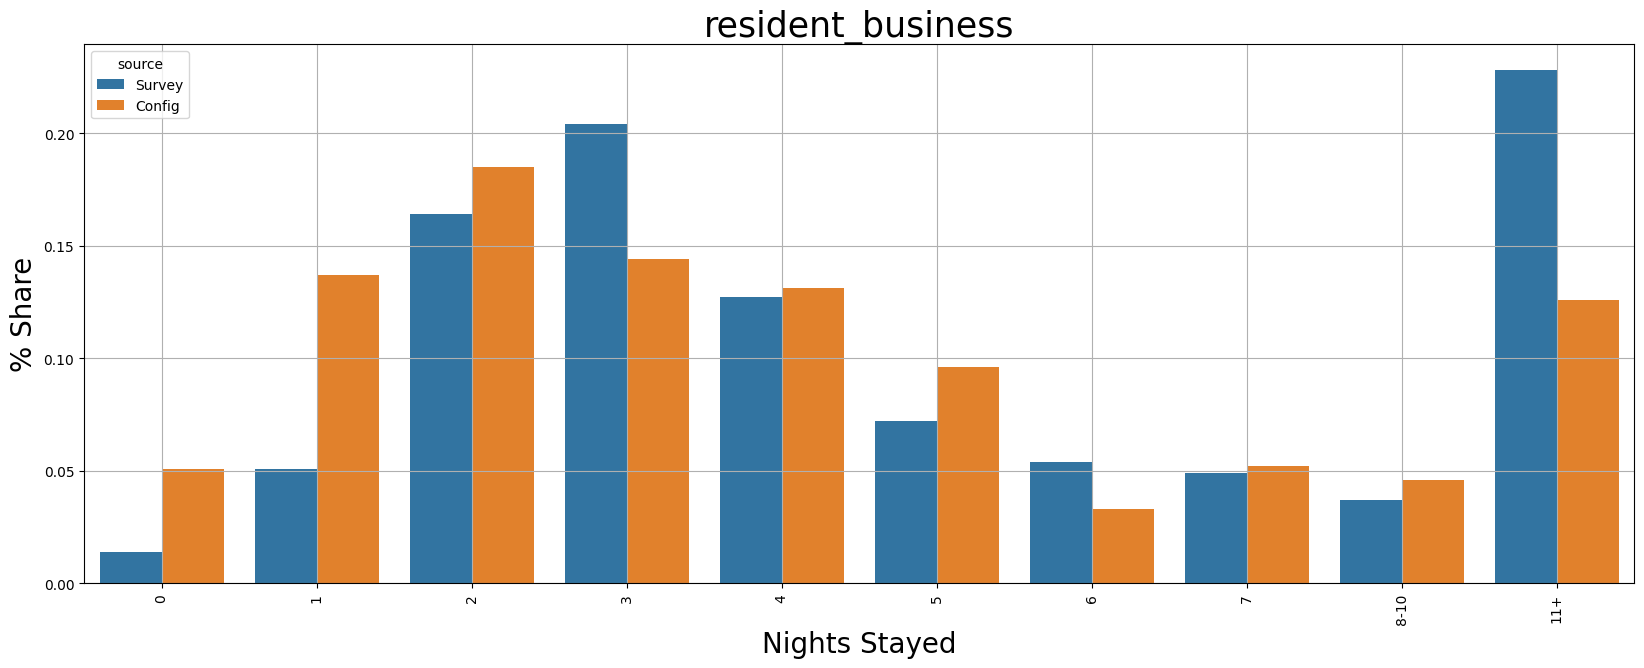

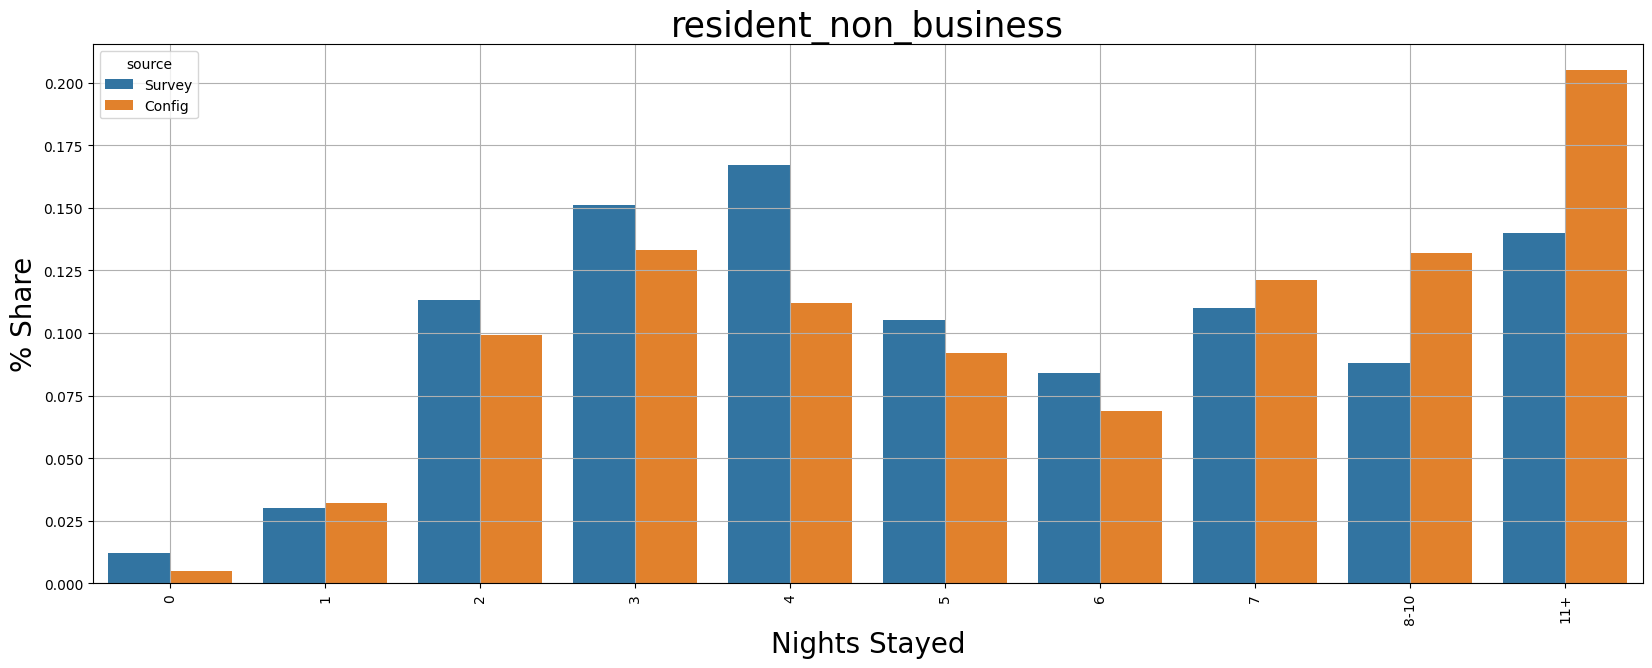

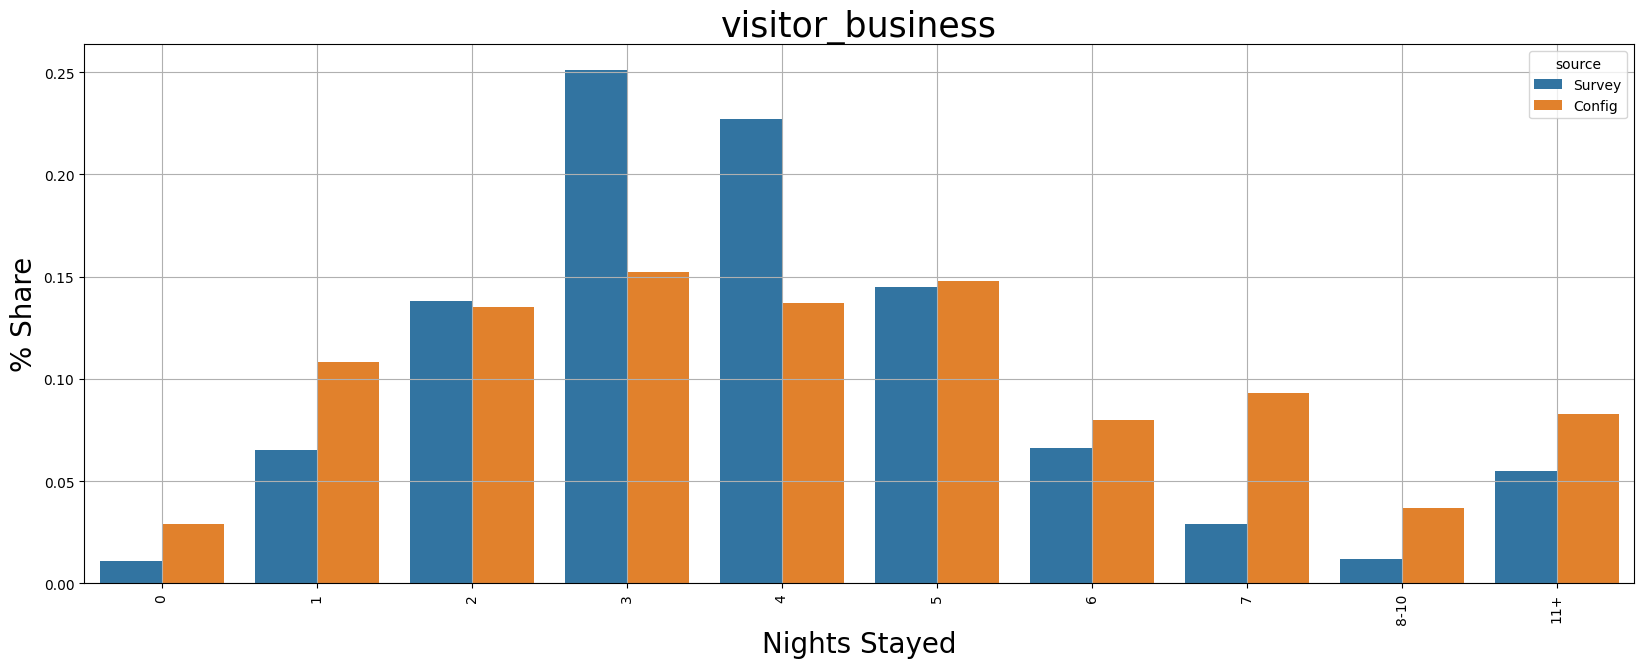

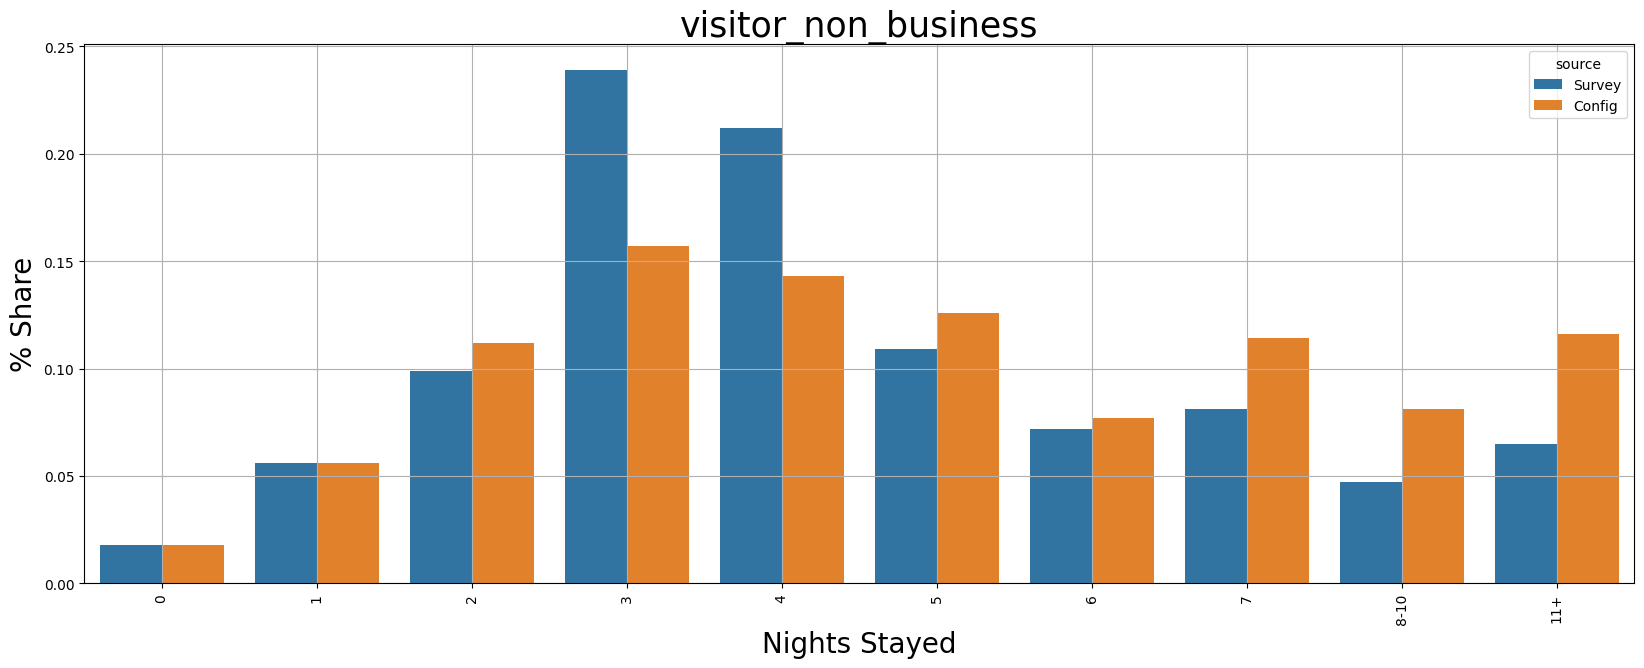

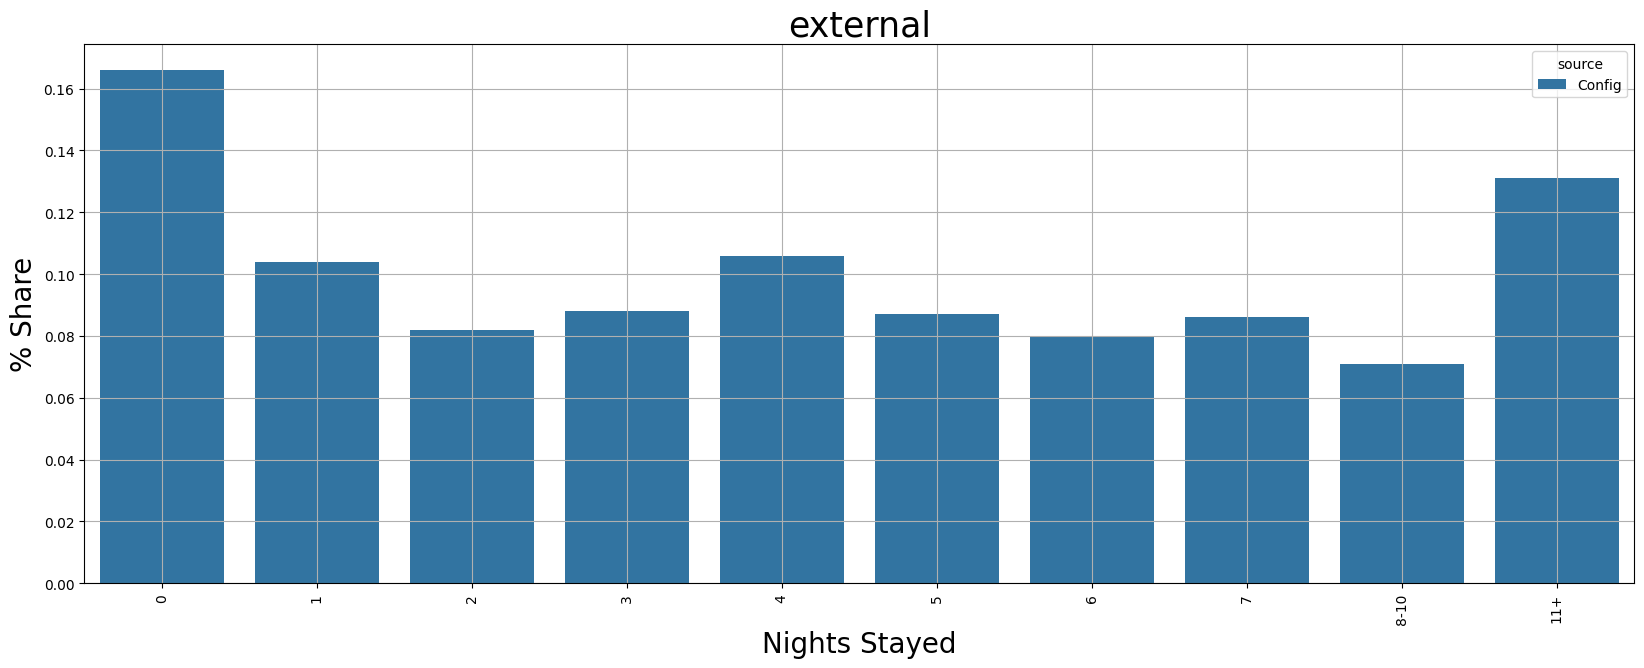

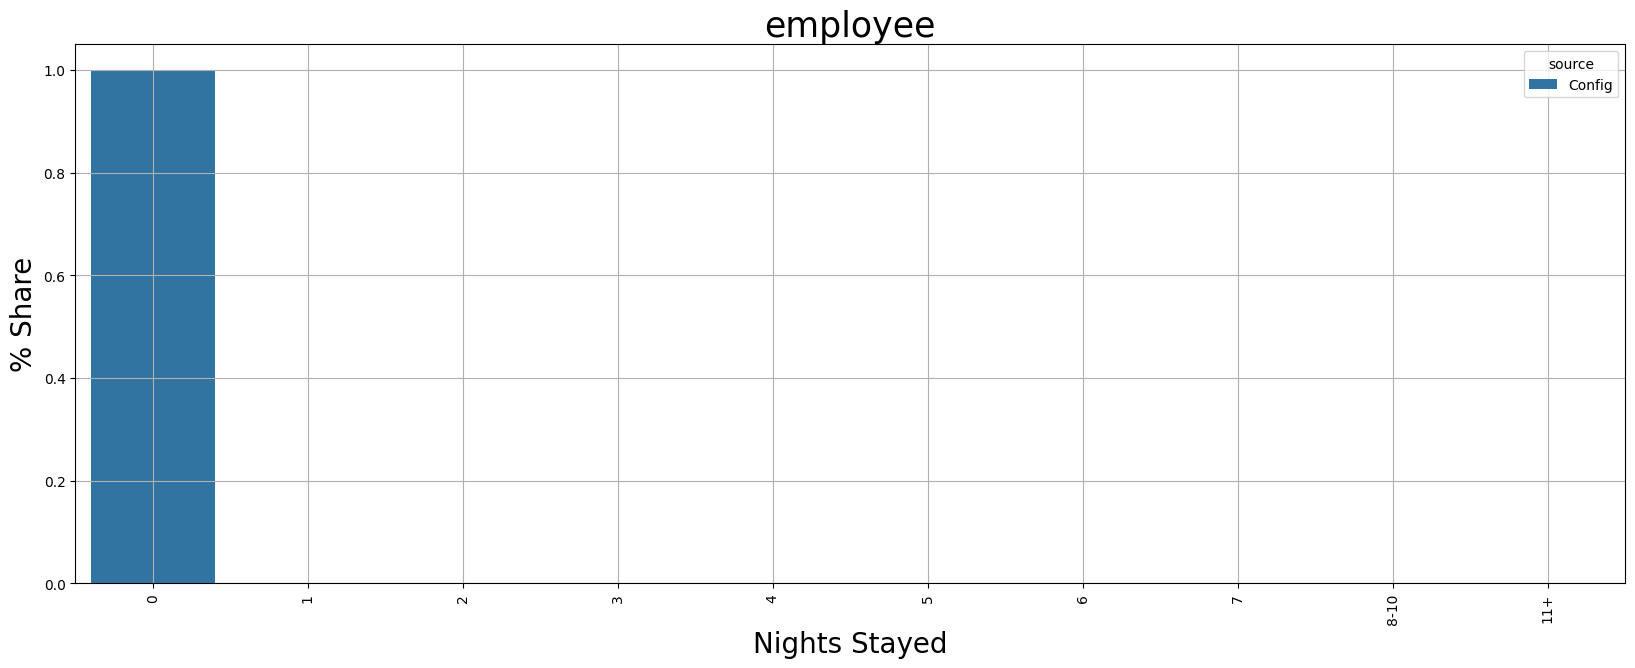

In [126]:
x = 'nights'
survey_compare = survey_night_purp_compare.melt(id_vars = x, var_name = 'purpose_segment')
config_compare = config_nights_purp
xlabel = 'Nights Stayed'
clustered_bar_charts(survey_compare, config_compare, x, xlabel)

In [127]:
survey_night_purp_melt = survey_night_purp_compare.melt(id_vars='nights', var_name='variable')
survey_night_purp_melt['source'] = 'Survey'
config_night_purp_melt= config_nights_purp.melt(id_vars='nights')
config_night_purp_melt['source'] = 'Config'
night_purp_compare = pd.concat([survey_night_purp_melt, config_night_purp_melt])
night_purp_compare.head()

,nights,variable,value,source
0,0,resident_business,0.014,Survey
1,1,resident_business,0.051,Survey
2,2,resident_business,0.164,Survey
3,3,resident_business,0.204,Survey
4,4,resident_business,0.127,Survey


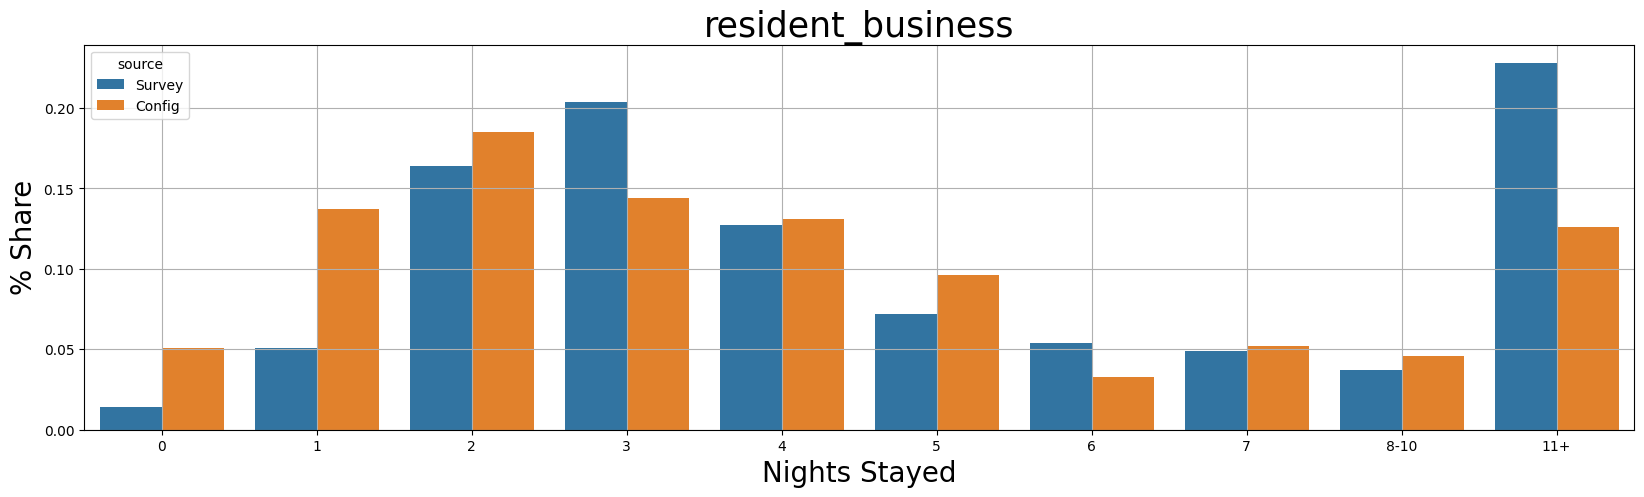

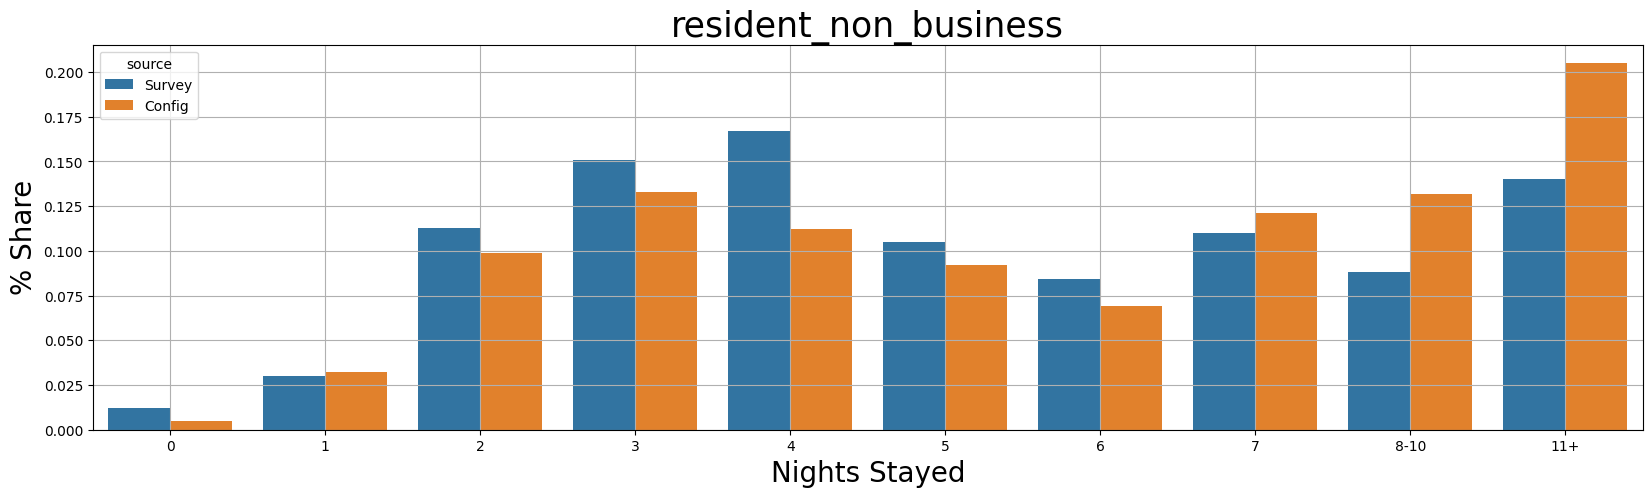

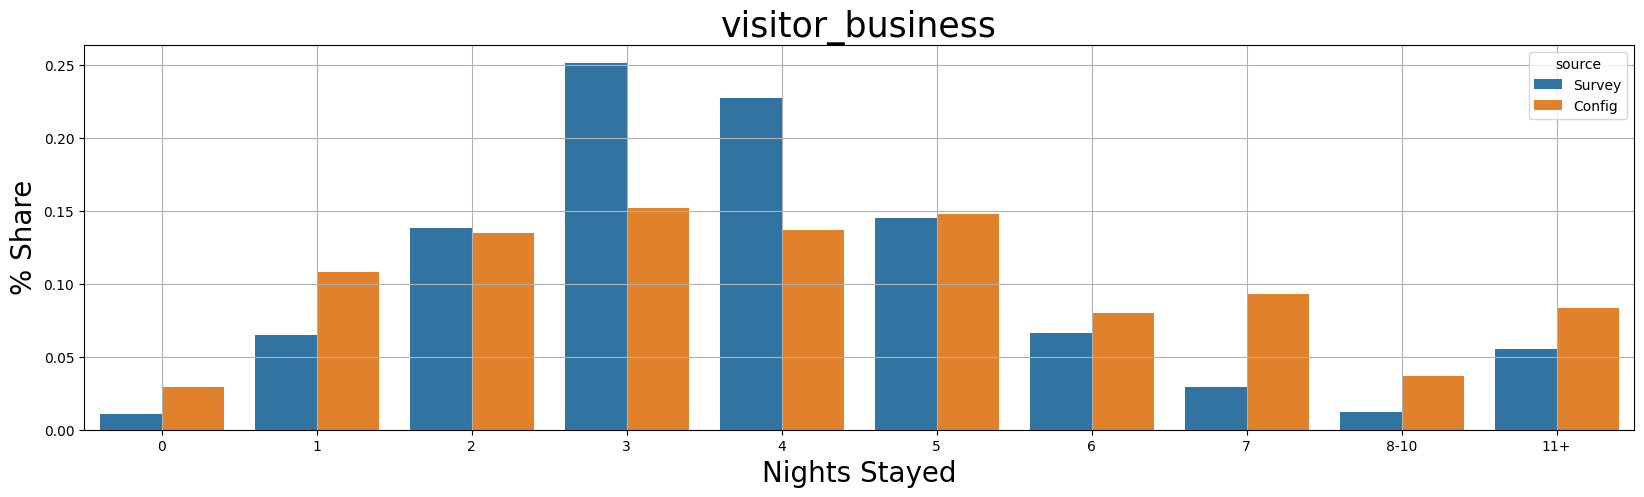

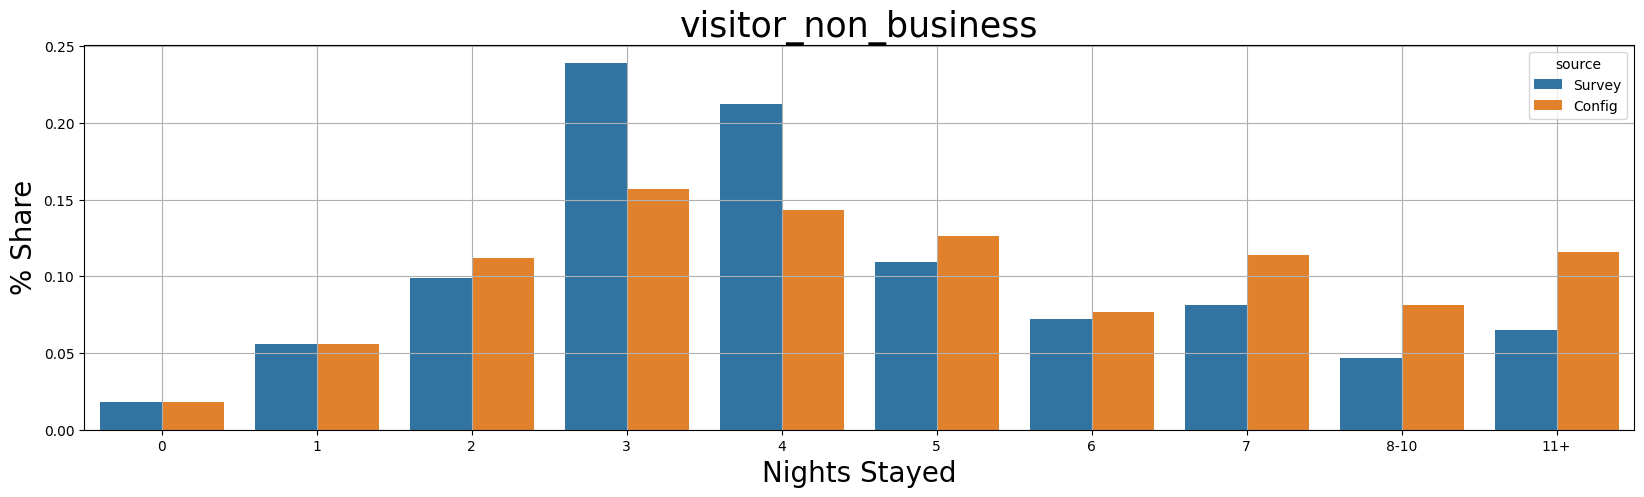

In [128]:
for survey_col in survey_night_purp_melt['variable'].unique():
    fig, ax = plt.subplots(figsize=(20,5))
    sns.barplot(
        data = (
            night_purp_compare
                .query(f'variable == "{survey_col}"')
        ),
        x='nights',
        y='value',
        hue='source'
    )
    # ax.tick_params(axis='x', labelrotation=45)
    plt.title(f'{survey_col}', fontsize=25)
    plt.ylabel("% Share", fontsize=20)
    plt.xlabel("Nights Stayed", fontsize=20)
    plt.grid()
    plt.show()


## airport_party
- CONFIG: Party size (0 through 5+)
    - looking at config data, it appears that party size includes traveler
- SURVEY: <party_size_ground_access>- Size of ground access travel party (count excludes the respondent)
    - <part_size_flight> is inferior column for this analysis


### Survey

In [129]:
survey_party = (
    survey_data_base.copy()
        .query('purpose_segment != "EMPLOYEE"') #employee party_size is always NULL
)
# move party count from "excluding respondent" to "including respondent"
survey_party_dict = {'ZERO': '1', 'ONE': '2', 'TWO': '3',
                     'THREE': '4', 'FOUR': '5+', 'FIVE': '5+',
                     'SIX': '5+', 'SEVEN_OR_MORE': '5+'}
survey_party['party'] = (survey_party
                         ['party_size_ground_access_label']
                         .fillna('ZERO')
                         .str.replace('NONE','ZERO')
                         .map(survey_party_dict)
)

In [150]:
survey_party_compare = (
    survey_party
    .pivot_table(
        index='party',
        columns='purpose_segment',
        aggfunc='sum',
        values='weight_departing_only'
        )
    .fillna(0)
    .apply(lambda x: x/sum(x))
    .round(3)
    [[p for p in purpose_order if p!= 'external']]
    .reset_index(drop=False)
)
survey_party_compare.columns.name = None
survey_party_compare

,party,resident_business,resident_non_business,visitor_business,visitor_non_business,employee
0,1,0.594,0.323,0.419,0.265,1.0
1,2,0.123,0.278,0.152,0.253,0.0
2,3,0.074,0.144,0.068,0.123,0.0
3,4,0.046,0.083,0.067,0.107,0.0
4,5+,0.164,0.172,0.294,0.251,0.0


In [151]:
# # investigate respondents where party size is not Null but party ground access is
# (survey_party
#     .query('~party_size_flight_label.isnull()')
#     .query('party_size_ground_access_label.isnull()')
#     .fillna('----')
#     .groupby(['party_size_flight_label','party_size_ground_access_same','party_size_ground_access_label'])
#     ['unique_id']
#     .count()
# )

### Config

In [152]:
config_party = pd.read_csv(os.path.join(configs_path, 'airport_party.SAN.csv'))
config_party = config_party.query('party > 0') # row is empty

config_party_dict = {0: '0', 1: '1', 2: '2', 3: '3', 4: '4', 5: '5+'}
config_party['party'] = config_party['party'].map(config_party_dict)

config_party.rename(columns = config_purpose_dict, inplace=True)

config_party

,party,resident_business,resident_non_business,visitor_business,visitor_non_business,external,employee
1,1,0.871,0.569,0.689,0.472,0.546,1
2,2,0.088,0.281,0.223,0.308,0.273,0
3,3,0.022,0.063,0.044,0.090,0.085,0
4,4,0.002,0.048,0.024,0.075,0.048,0
5,5+,0.017,0.039,0.021,0.055,0.048,0


### Compare

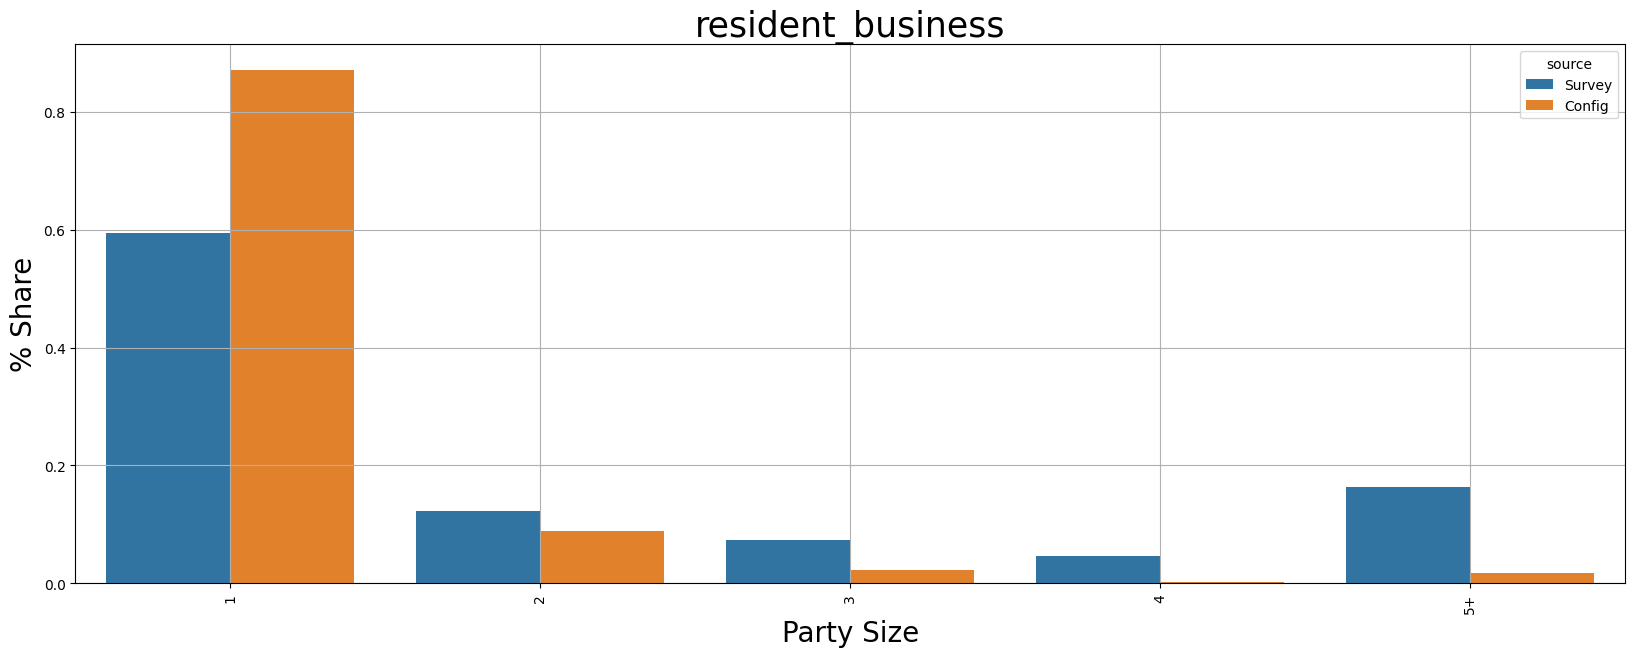

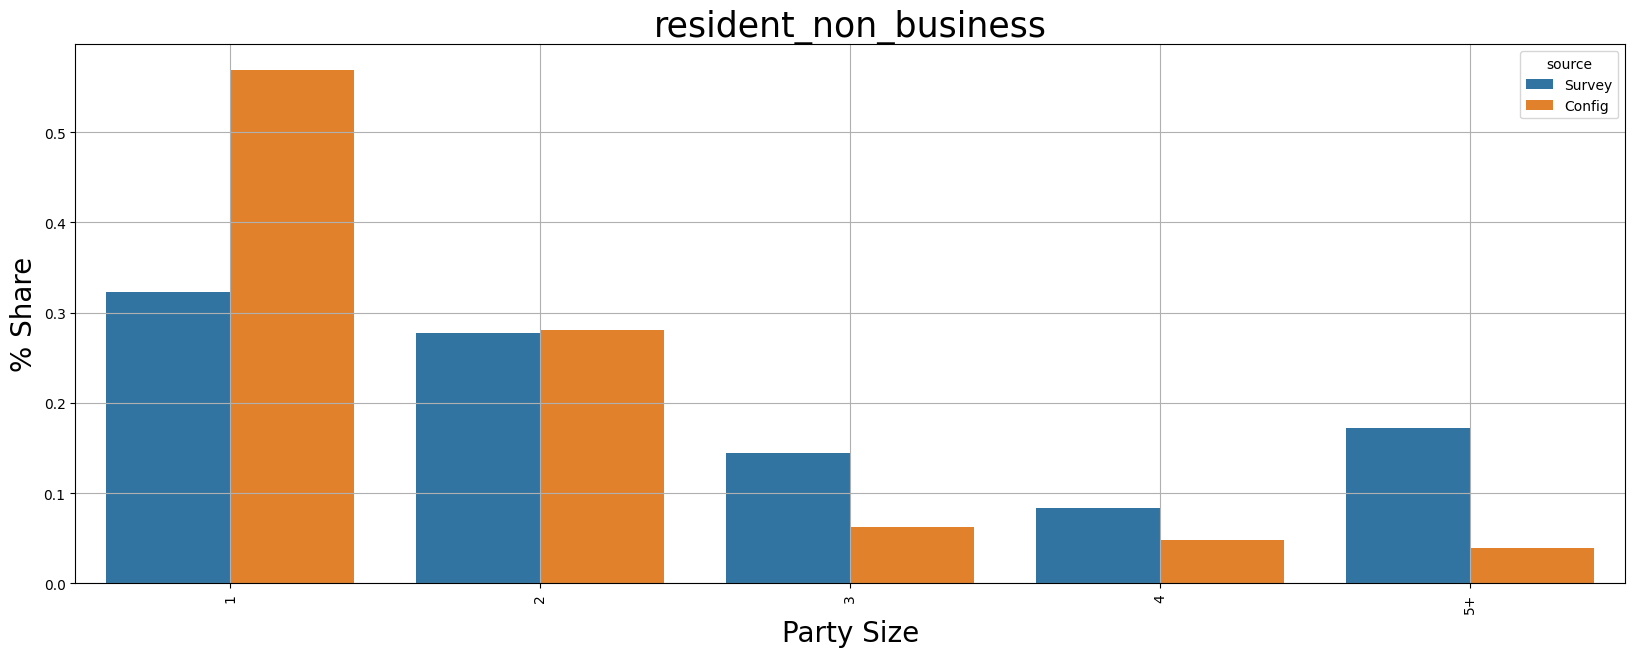

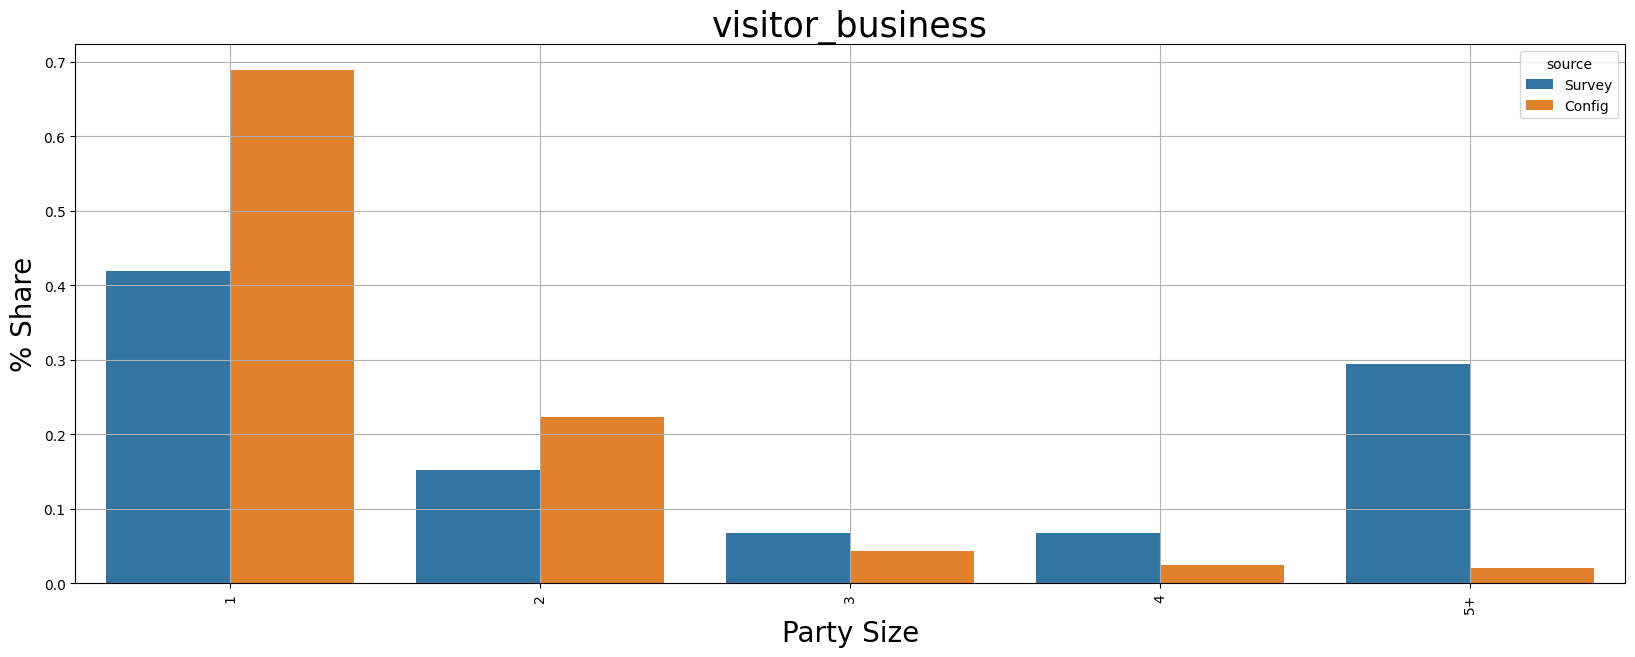

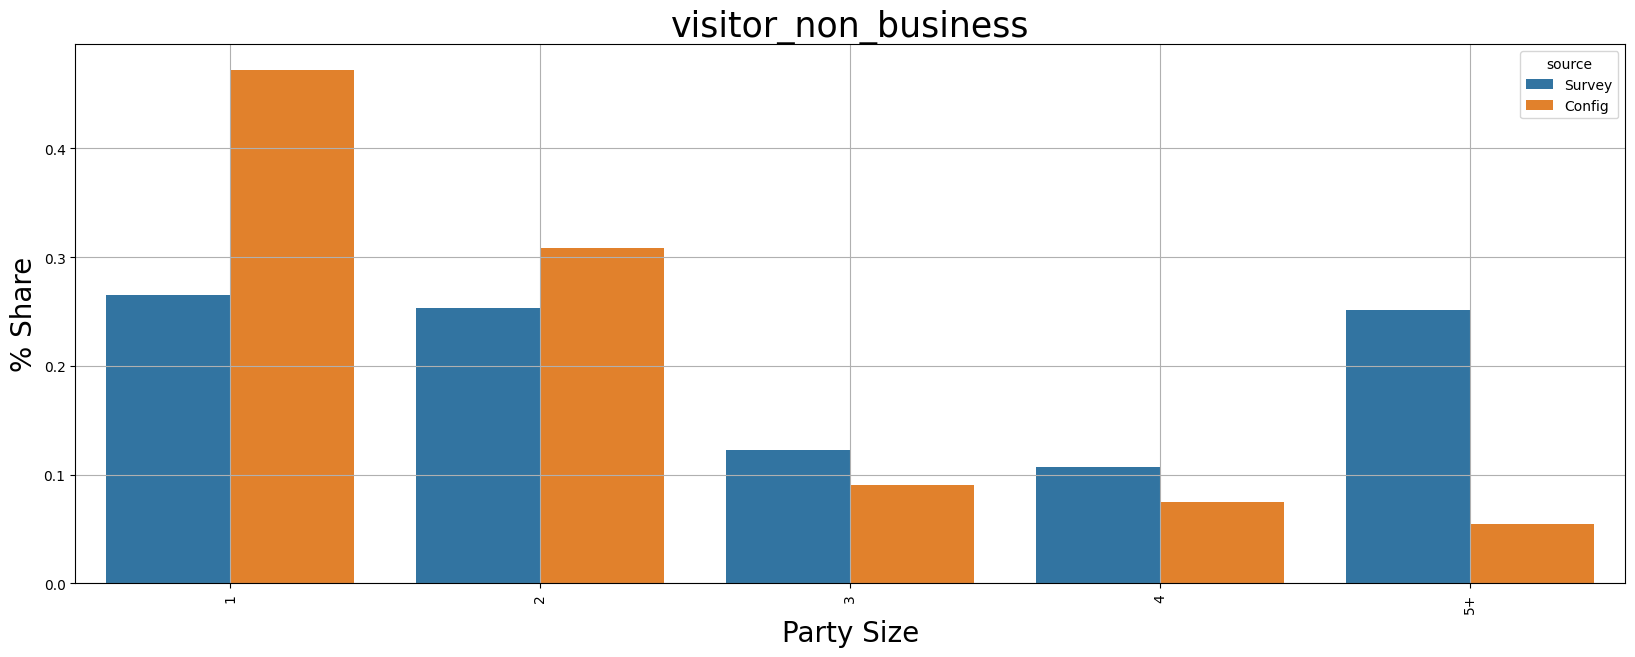

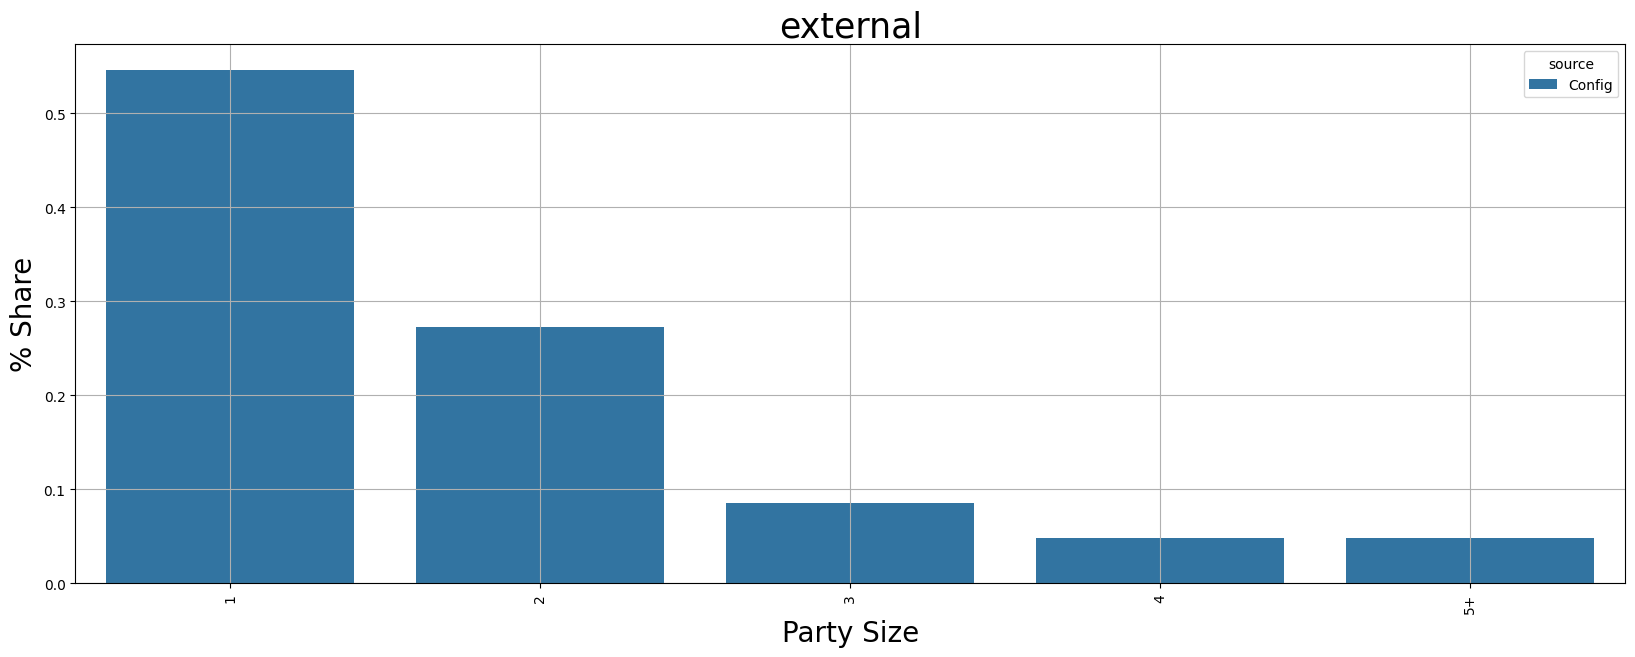

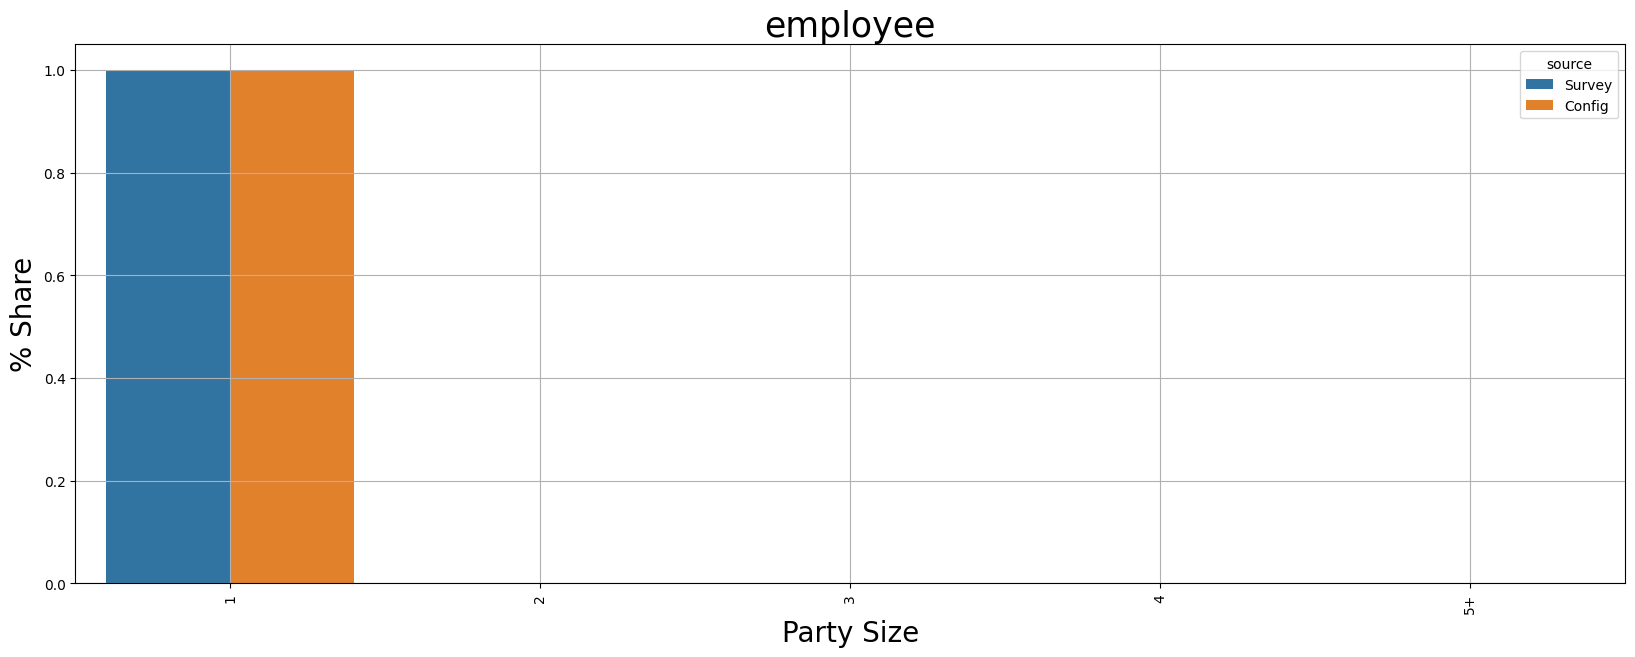

In [153]:
x = 'party'
survey_compare = survey_party_compare.melt(id_vars = x, var_name = 'purpose_segment')
config_compare = config_party
xlabel = 'Party Size'
clustered_bar_charts(survey_compare, config_compare, x, xlabel)

## destination_choice_size_terms
'destination_choice_size_terms.csv'

In [154]:
pd.read_csv(os.path.join(configs_path, 'destination_choice_size_terms.csv')).head()

,model_selector,segment,a1,a2,a3,a4,a5,a6,a7,a8,...,emp_accm,emp_oth,emp_mnf,emp_mil,emp_fin_res_mgm,emp_bus_svcs,emp_food,emp_utl,emp_whl,emp_trn_wrh
0,non_mandatory,res_bus1,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.015154,0.015154,0.015154,0.006896,0.013142,0.014148,0.015154,0.015154,0.015154,0.015154
1,non_mandatory,res_bus2,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.015154,0.015154,0.015154,0.006896,0.013142,0.014148,0.015154,0.015154,0.015154,0.015154
2,non_mandatory,res_bus3,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,...,0.015154,0.015154,0.015154,0.006896,0.013142,0.014148,0.015154,0.015154,0.015154,0.015154
3,non_mandatory,res_bus4,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,...,0.015154,0.015154,0.015154,0.006896,0.013142,0.014148,0.015154,0.015154,0.015154,0.015154
4,non_mandatory,res_bus5,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,...,0.015154,0.015154,0.015154,0.006896,0.013142,0.014148,0.015154,0.015154,0.015154,0.015154


## InternalExternalDestinationChoiceAlternatives
'InternalExternalDestinationChoiceAlternatives.csv'

not sure if we have the volume of data to support amending this chart ... 
- is telemetrics an option?

In [155]:
pd.read_csv(os.path.join(configs_path, 'InternalExternalDestinationChoiceAlternatives.csv'))

,alt,taz,name,mgraOut,mgraRet,region,iePct,CBX.Pct,SAN.Pct
0,1,1,San Ysidro,24064,9279,1,0.0669,0.000,0.000
1,2,2,Otay Mesa,9384,9387,1,0.0169,0.000,0.000
2,3,3,East Otay Mesa,9402,9402,1,0.0000,0.000,0.000
3,4,4,Tecate,22324,22324,1,0.0053,0.000,0.000
4,5,5,Jacumba,22698,22698,1,0.0000,0.000,0.000
5,6,6,I-8,21955,21955,2,0.0463,0.025,0.025
6,7,7,SR78,23579,23579,2,0.0047,0.027,0.027
7,8,8,SR79,21426,21426,3,0.0064,0.008,0.008
8,9,9,Pala Road,17571,17571,3,0.0096,0.009,0.009
9,10,10,I-15,16902,16902,3,0.3985,0.125,0.125


## non_mandatory_tour_destination_coefficients
'non_mandatory_tour_destination_coefficients.csv'

In [156]:
pd.read_csv(os.path.join(configs_path, 'non_mandatory_tour_destination_coefficients.csv')).head()

,coefficient_name,value,constrain
0,coef_one,1.00000,T
1,coef_zero,0.00000,T
2,coef_int_res_bus,-0.00329,NaN
3,coef_int_res_per,-0.00164,NaN
4,coef_int_vis_bus,-0.00608,NaN


## stop_frequency_coefficients
stop_frequency_coefficients.csv

In [157]:
pd.read_csv(os.path.join(configs_path, 'stop_frequency_coefficients.csv'))

,Description,value,coefficient_name
0,NaN,-999,coef_zero
1,NaN,1,coef_one


## WIP_tour_scheduling_probs
'tour_scheduling_probs.csv'

In [158]:
pd.read_csv(os.path.join(configs_path, 'tour_scheduling_probs.csv'))

,purpose,outbound,1_1,1_2,1_3,1_4,1_5,1_6,1_7,1_8,...,39_48,40_48,41_48,42_48,43_48,44_48,45_48,46_48,47_48,48_48
0,purp0_perc,True,0.02450,0.02450,0.02450,0.02450,0.082,0.056,0.086,0.058,...,0.000,0.000,0.000,0.000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
1,purp1_perc,True,0.02000,0.02000,0.02000,0.02000,0.049,0.048,0.068,0.056,...,0.000,0.000,0.000,0.000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
2,purp2_perc,True,0.01150,0.01150,0.01150,0.01150,0.030,0.032,0.045,0.031,...,0.000,0.000,0.000,0.000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
3,purp3_perc,True,0.01000,0.01000,0.01000,0.01000,0.026,0.026,0.035,0.029,...,0.000,0.000,0.000,0.000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
4,purp4_perc,True,0.01825,0.01825,0.01825,0.01825,0.033,0.029,0.047,0.021,...,0.000,0.000,0.000,0.000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
5,purp5_perc,True,0.01100,0.01100,0.01100,0.01100,0.044,0.044,0.034,0.034,...,0.000,0.000,0.000,0.000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
6,purp0_perc,False,0.00000,0.00000,0.00000,0.00000,0.000,0.000,0.000,0.000,...,0.041,0.036,0.006,0.003,0.000167,0.000167,0.000167,0.000167,0.000167,0.000167
7,purp1_perc,False,0.00000,0.00000,0.00000,0.00000,0.000,0.000,0.000,0.000,...,0.041,0.036,0.006,0.003,0.000167,0.000167,0.000167,0.000167,0.000167,0.000167
8,purp2_perc,False,0.00000,0.00000,0.00000,0.00000,0.000,0.000,0.000,0.000,...,0.041,0.036,0.006,0.003,0.000167,0.000167,0.000167,0.000167,0.000167,0.000167
9,purp3_perc,False,0.00000,0.00000,0.00000,0.00000,0.000,0.000,0.000,0.000,...,0.041,0.036,0.006,0.003,0.000167,0.000167,0.000167,0.000167,0.000167,0.000167


## WIP_trip_scheduling_probs
'trip_scheduling_probs.csv'

In [159]:
# TODO is this even used????

In [160]:
pd.read_csv(os.path.join(configs_path, 'trip_scheduling_probs.csv'))

,primary_purpose,outbound,tour_hour,trip_num,HR1,HR2,HR3,HR4,HR5,HR6,...,HR39,HR40,HR41,HR42,HR43,HR44,HR45,HR46,HR47,HR48
0,work,True,1,1,1.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,work,True,1,2,0.0,1.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,work,True,1,3,0.0,1.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,work,True,1,4,0.0,1.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,work,True,2,1,0.0,1.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3451,eatout,False,47,4,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
3452,eatout,False,48,1,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
3453,eatout,False,48,2,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
3454,eatout,False,48,3,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0


# New Analysis

In [161]:
# TODO: analyse 'party_includes_mobility_impaired'

In [162]:
# TODO: should 'sdia_flight_frequency' affect weighting??

In [163]:
# # non-synthetic outbound_from_airport trips have flight_arrival_time
# #   instead of trip_arrival_time
# survey_temp = survey_data_base.copy()
# survey_temp['has_trip_start_time'] = survey_temp['trip_arrival_time'].notna()
# survey_temp['has_flight_arrival_time']= survey_temp['flight_arrival_time'].notna()
# (
#     survey_temp
#         .groupby([
#             'record_type_synthetic',
#             'inbound_or_outbound_label',
#             'has_trip_start_time',
#             'has_flight_arrival_time'])
#         ['unique_id']
#         .count()
#         .rename('count')
#         .to_frame()
#         .reset_index(drop=False)
# )

In [164]:
# survey_data_base.fillna('----').groupby(['main_mode_label','sdia_previous_accessmode_label'])['unique_id'].count()